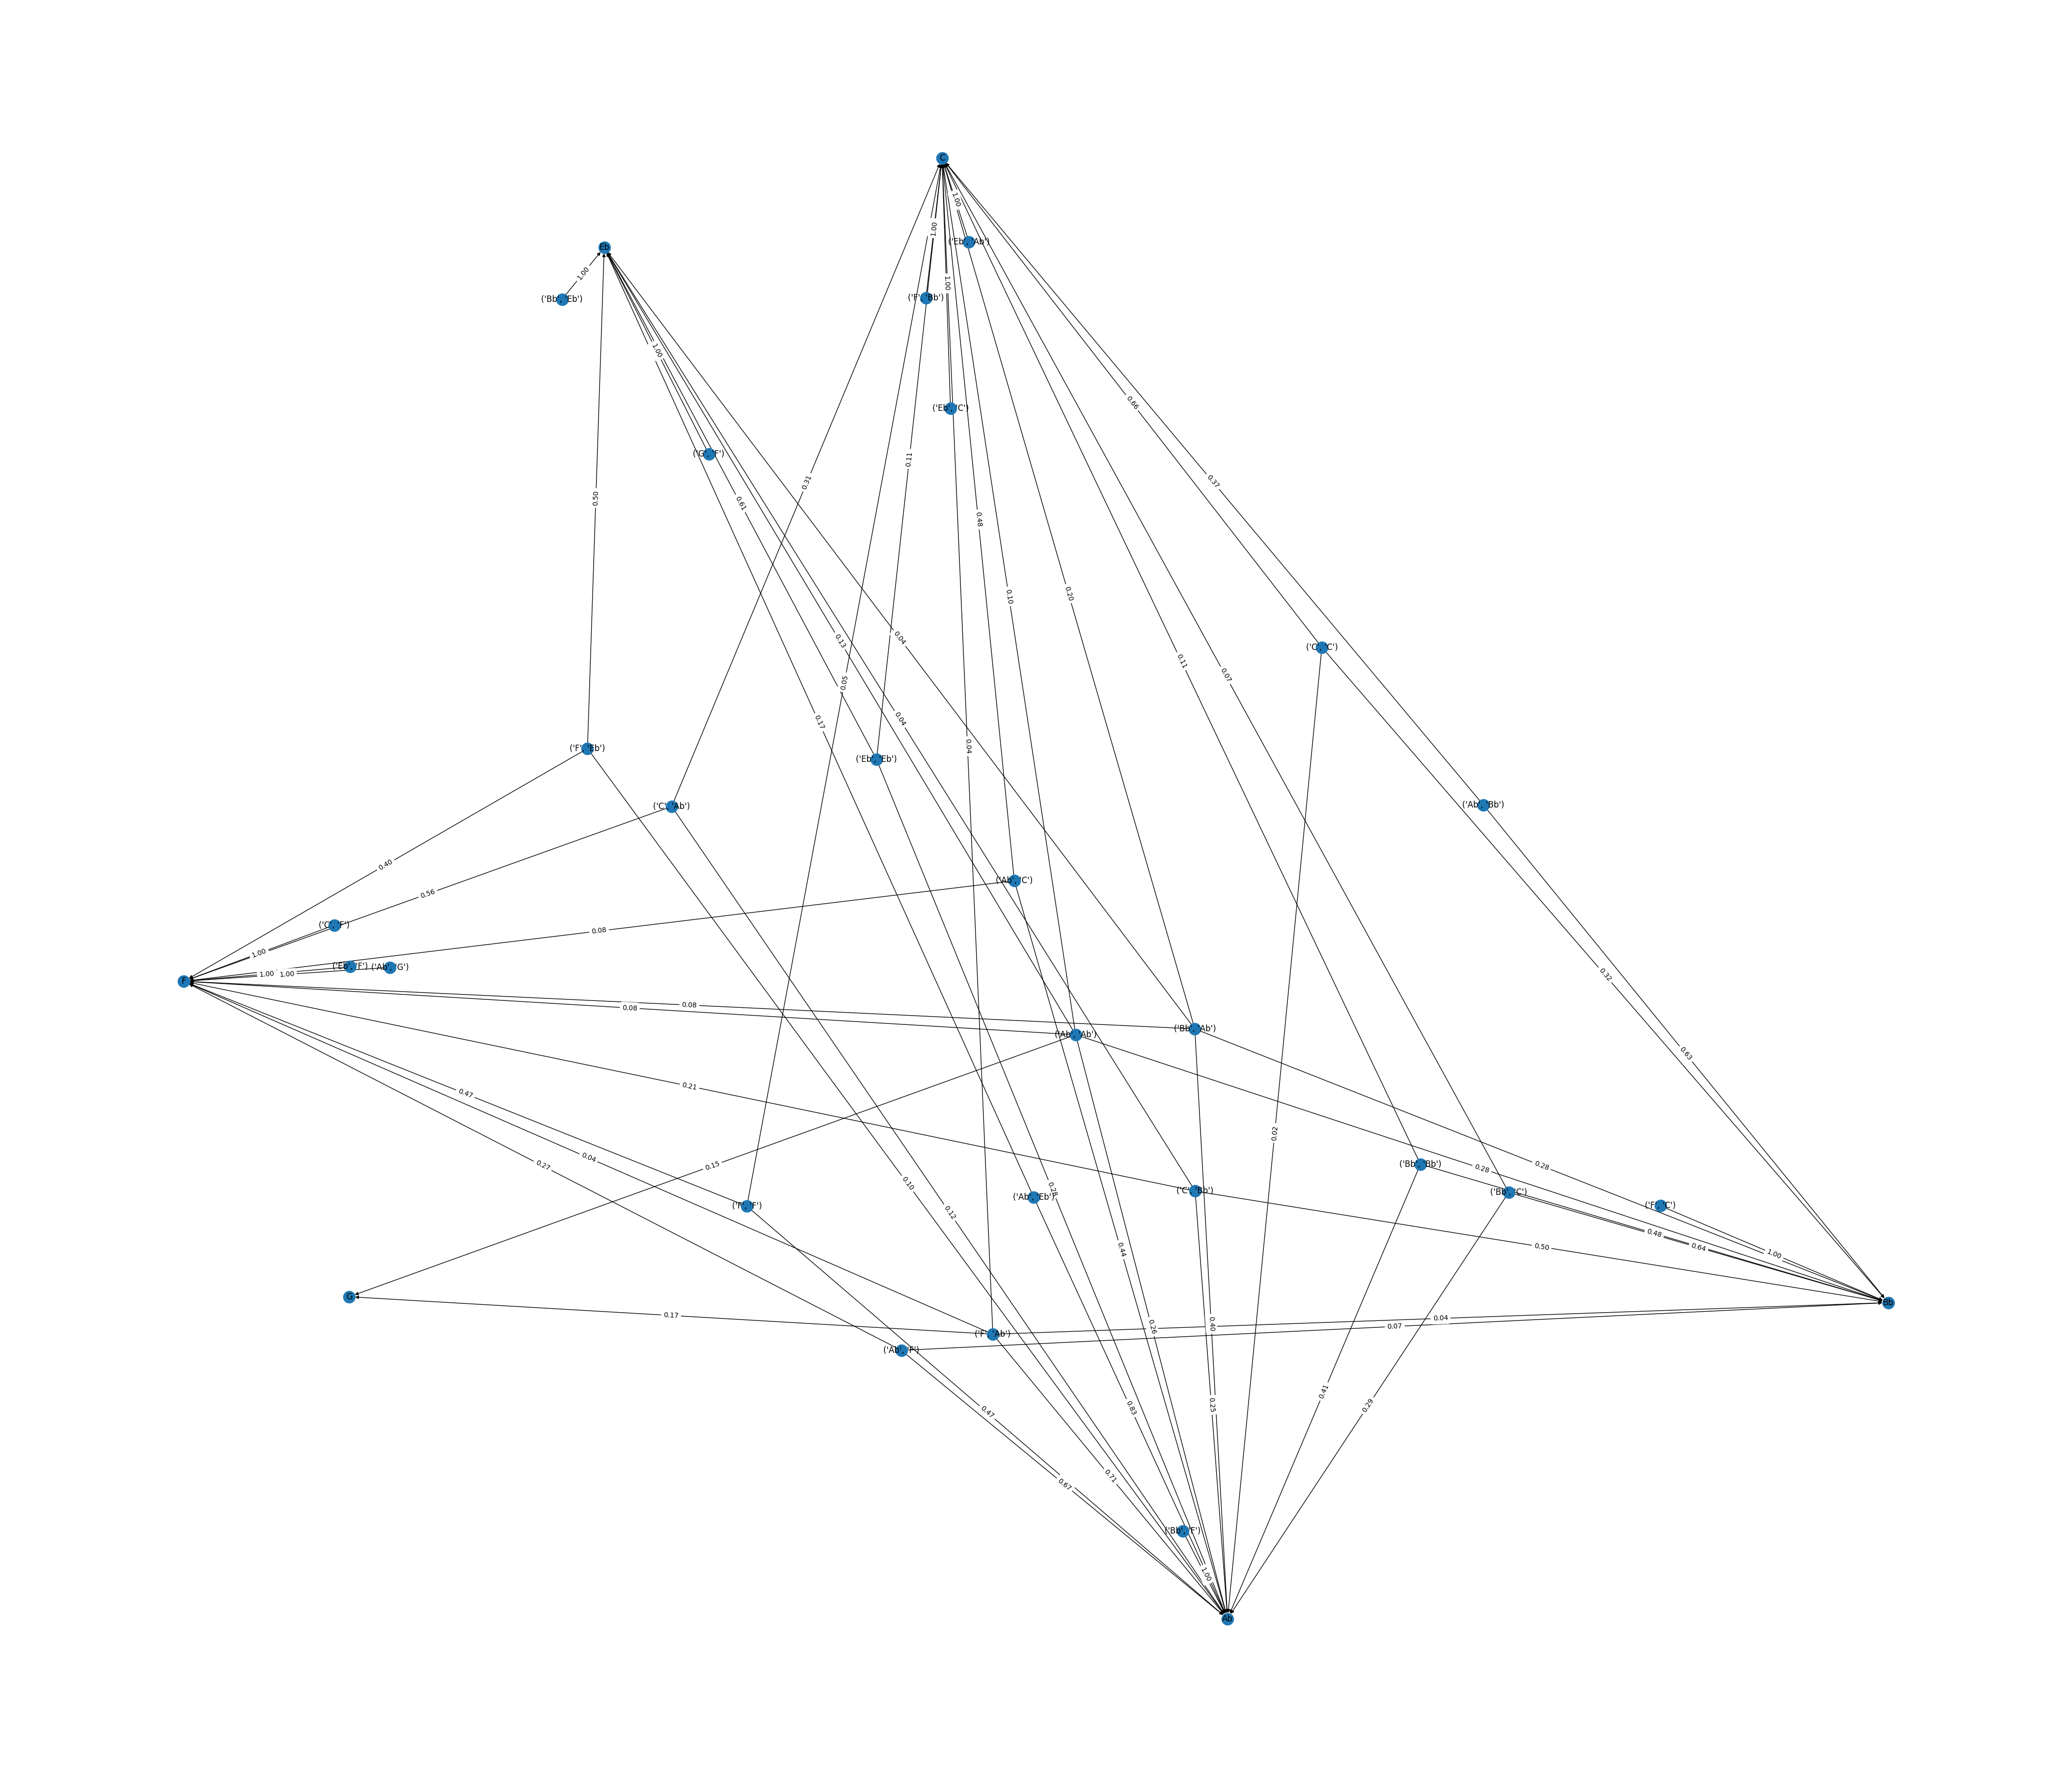

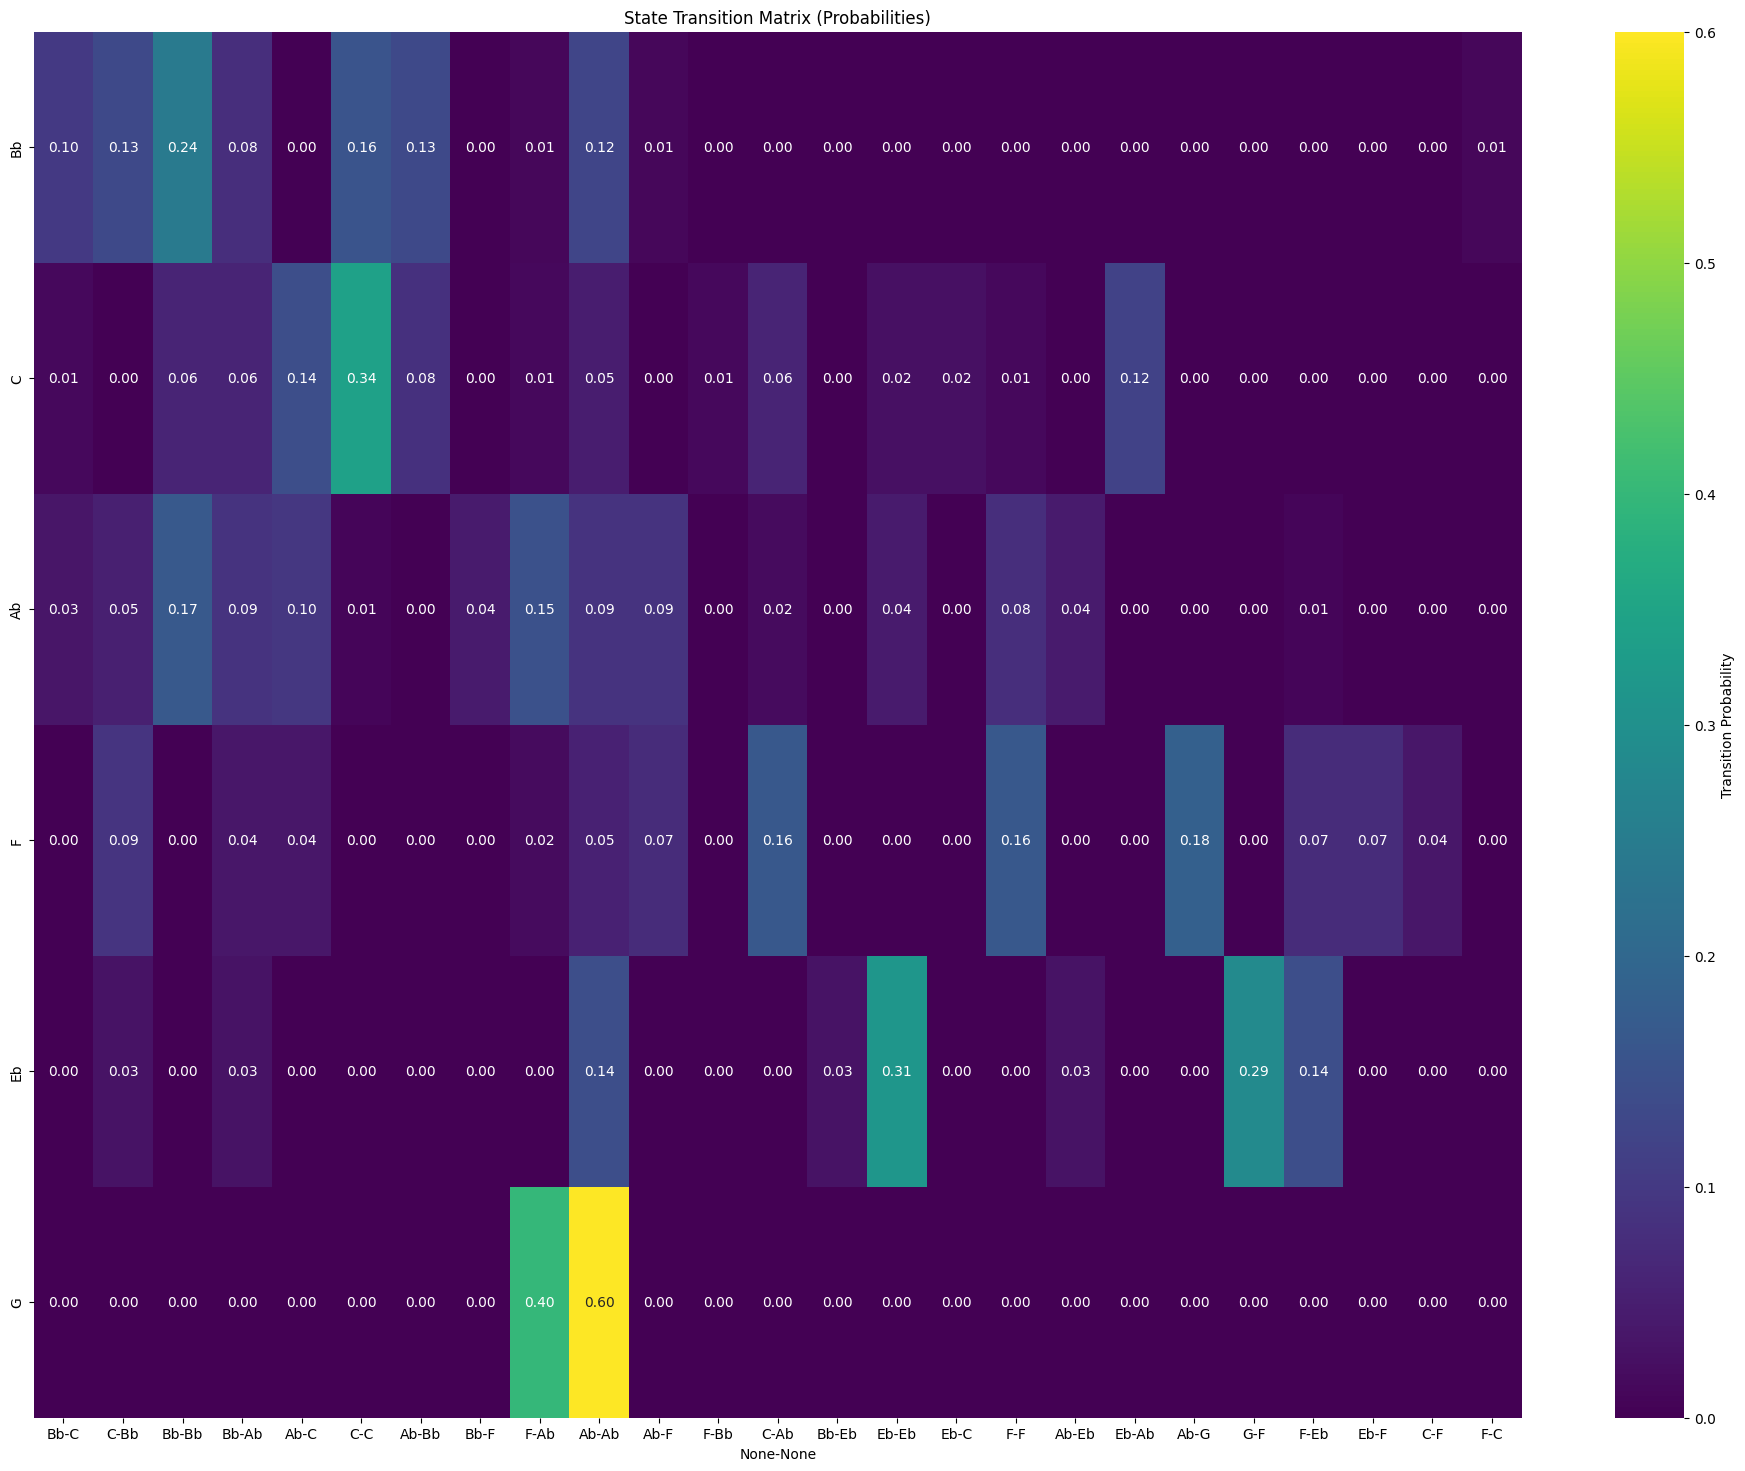

Chords in 'chord_progression.csv': ['Bb' 'C' 'Bb' 'Bb' 'Ab' 'C' 'C' 'C' 'C' 'C' 'C' 'Bb' 'Bb' 'Ab' 'Bb' 'C'
 'Bb' 'F' 'Ab' 'Ab' 'C' 'C' 'Bb' 'Ab' 'Bb' 'Bb' 'Bb' 'Bb' 'C' 'C' 'C' 'C'
 'C' 'C' 'C' 'C' 'C' 'Bb' 'Ab' 'Ab' 'Ab' 'Bb' 'Bb' 'Bb' 'Ab' 'Ab' 'F' 'Bb'
 'C' 'Bb' 'Bb' 'Bb' 'C' 'Ab' 'C' 'C' 'C' 'C' 'C' 'C' 'Bb' 'Bb' 'Ab' 'Bb'
 'C' 'Bb' 'F' 'Ab' 'Ab' 'Ab' 'C' 'C' 'Bb' 'Bb' 'Bb' 'C' 'Ab' 'C' 'C' 'C'
 'C' 'C' 'C' 'Bb' 'Bb' 'Ab' 'Bb' 'C' 'Bb' 'F' 'Ab' 'Ab' 'Ab' 'C' 'C' 'Bb'
 'Eb' 'Eb' 'Eb' 'C' 'C' 'Bb' 'Ab' 'Ab' 'C' 'C' 'Bb' 'Bb' 'Ab' 'Ab' 'F' 'F'
 'Ab' 'Ab' 'Bb' 'Bb' 'Bb' 'Ab' 'F' 'F' 'F' 'F' 'Ab' 'Ab' 'Bb' 'Bb' 'Bb'
 'Bb' 'Ab' 'Ab' 'Eb' 'Ab' 'C' 'Ab' 'C' 'Ab' 'Ab' 'Ab' 'Ab' 'G' 'F' 'Eb'
 'Eb' 'Eb' 'Eb' 'Ab' 'C' 'Ab' 'F' 'Ab' 'G' 'F' 'Eb' 'F' 'F' 'F' 'Ab' 'Ab'
 'Bb' 'Bb' 'Bb' 'Ab' 'C' 'C' 'C' 'C' 'Ab' 'Ab' 'Bb' 'Bb' 'Bb' 'Bb' 'Ab'
 'Ab' 'Eb' 'Ab' 'C' 'Ab' 'F' 'Ab' 'Ab' 'G' 'F' 'Eb' 'Eb' 'Eb' 'Eb' 'Ab'
 'C' 'Ab' 'F' 'Ab' 'G' 'F' 'Eb' 'F' 'F' 'F' 'Ab' 'Ab' 'Bb' 'Bb' 'Bb' 'Ab'
 'C' 'F' 'F'

In [38]:
import numpy as np
import pandas as pd
from collections import Counter
!pip install midiutil
!pip install networkx
from collections import Counter
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns

from midiutil import MIDIFile

# Define a mapping from chord names to MIDI note numbers (you may need to adjust these)
chord_mapping = {
    'C': 72,
    'C#': 73, 'C#m': 73,
    'Db': 73, 'Dbm': 73,
    'D': 74, 'Dm': 74,
    'D#': 75, 'D#m': 75,
    'Eb': 75, 'Ebm': 75,
    'E': 76, 'Em': 76,
    'F': 77, 'Fm': 77,
    'F#': 78, 'F#m': 78,
    'Gb': 78, 'Gbm': 78,
    'G': 79, 'Gm': 79,
    'G#': 80, 'G#m': 80,
    'Ab': 80, 'Abm': 80,
    'A': 81, 'Am': 81,
    'A#': 82, 'A#m': 82,
    'Bb': 82, 'Bbm': 82,
    'B': 83, 'Bm': 83,
}




def predict_next_state(chord, ngrams):
    """Predict next chord based on the current state."""
    # create list of n-grams which start with the current chord
    ngrams_with_current_chord = []
    print("Chord:", chord)
    for ngram in ngrams:
        if ngram[:-1] == chord:
            ngrams_with_current_chord.append(ngram)

    
    # count appearance of each n-gram
    count_appearance = dict(Counter(ngrams_with_current_chord))
    # convert appearance into probabilities
    for ngram in count_appearance.keys():
        count_appearance[ngram] = count_appearance[ngram] / len(ngrams_with_current_chord)
    
    # create list of possible options for the next chord
    options = [key[-1] for key in count_appearance.keys()]
    # create a list of probability distribution
    probabilities = list(count_appearance.values())
    
    # check if options is not empty before making a random choice
    if options:
        return np.random.choice(options, p=probabilities)

def generate_sequence(chord, ngrams, length: int = 30):
    """Generate a sequence of defined length."""
    # create a list to store future chords
    chords = []
    for n in range(length):
        # append the next chord to the list
        next_chord = predict_next_state(chord, ngrams)
        chords.append(next_chord)
        # use the last chord in the sequence to predict the next chord
        chord = tuple(list(chord)[1:] + [next_chord])
    
    print("Chords:", chords)  # Print the chords for debugging
    return chords

def save_as_midi(sequence, output_file="generated_sequence.mid"):
    """Save the generated sequence as a MIDI file."""
    midi = MIDIFile(1)  # 1 track
    time = 0
    tempo = 120  # BPM

    midi.addTempo(0, time, tempo)

    for chord in sequence:
        print("chord to be saved: ", chord)
        midi.addNote(0, 0, chord_mapping[chord], time, 0.5, 80)  # Using arbitrary duration and velocity
        time+=1

    with open(output_file, "wb") as midi_file:
        midi.writeFile(midi_file)
        
def visualize_transition_matrix(ngrams):
    """Visualize the transition matrix."""
    transitions = {}
    for ngram in ngrams:
        current_state = ngram[:-1]
        next_state = ngram[-1]
        
        if current_state not in transitions:
            transitions[current_state] = {}
        
        if next_state not in transitions[current_state]:
            transitions[current_state][next_state] = 1
        else:
            transitions[current_state][next_state] += 1
    
    G = nx.DiGraph()
    for current_state, next_states in transitions.items():
        total_transitions = sum(next_states.values())
        for next_state, count in next_states.items():
            probability = count / total_transitions
            G.add_edge(current_state, next_state, weight=probability)
    
    plt.figure(figsize=(42, 36))  # Set the figure size (adjust the values as needed)
    pos = nx.spring_layout(G)
    nx.draw(G, pos, with_labels=True)
    labels = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx_edge_labels(G, pos, edge_labels={k: f"{v:.2f}" for k, v in labels.items()})
    plt.show()
    
def visualize_transition_matrix2(ngrams):
    transitions = {}
    for ngram in ngrams:
        current_state = ngram[:-1]
        next_state = ngram[-1]
        
        if current_state not in transitions:
            transitions[current_state] = {}
        
        if next_state not in transitions[current_state]:
            transitions[current_state][next_state] = 1
        else:
            transitions[current_state][next_state] += 1

    # Convert the dictionary to a Pandas DataFrame
    df = pd.DataFrame(transitions).fillna(0).astype(int)

    # Normalize the transition matrix to probabilities
    df_probabilities = df.div(df.sum(axis=1), axis=0)

    # Create a heatmap
    plt.figure(figsize=(24, 18))
    sns.heatmap(df_probabilities, annot=True, fmt='.2f', cmap='viridis', cbar_kws={'label': 'Transition Probability'})
    plt.title('State Transition Matrix (Probabilities)')
    plt.show()


def main():
    # read file
    
    # read right hand file
    data = pd.read_csv('/kaggle/input/left-right/Notes_Right.csv')
    
    
    n = 3  # considering triplets
    chords = data['chords'].values
    ngrams = zip(*[chords[i:] for i in range(n)])
    ngrams = [tuple(ngram) for ngram in ngrams]
    
    # Visualize the transition matrix
    visualize_transition_matrix(ngrams)
    visualize_transition_matrix2(ngrams)

    print("Chords in 'chord_progression.csv':", chords)
    print("N-grams:", ngrams)

    # Generate a sequence of chords
    sequence = generate_sequence(('Bb','C'), ngrams, 100)

    # Print the generated sequence
    print("Generated Sequence:", sequence)
    
    # Save the generated sequence as a MIDI file
    save_as_midi(sequence, output_file="generated_sequence_final_right.mid")

if __name__ == "__main__":
    main()



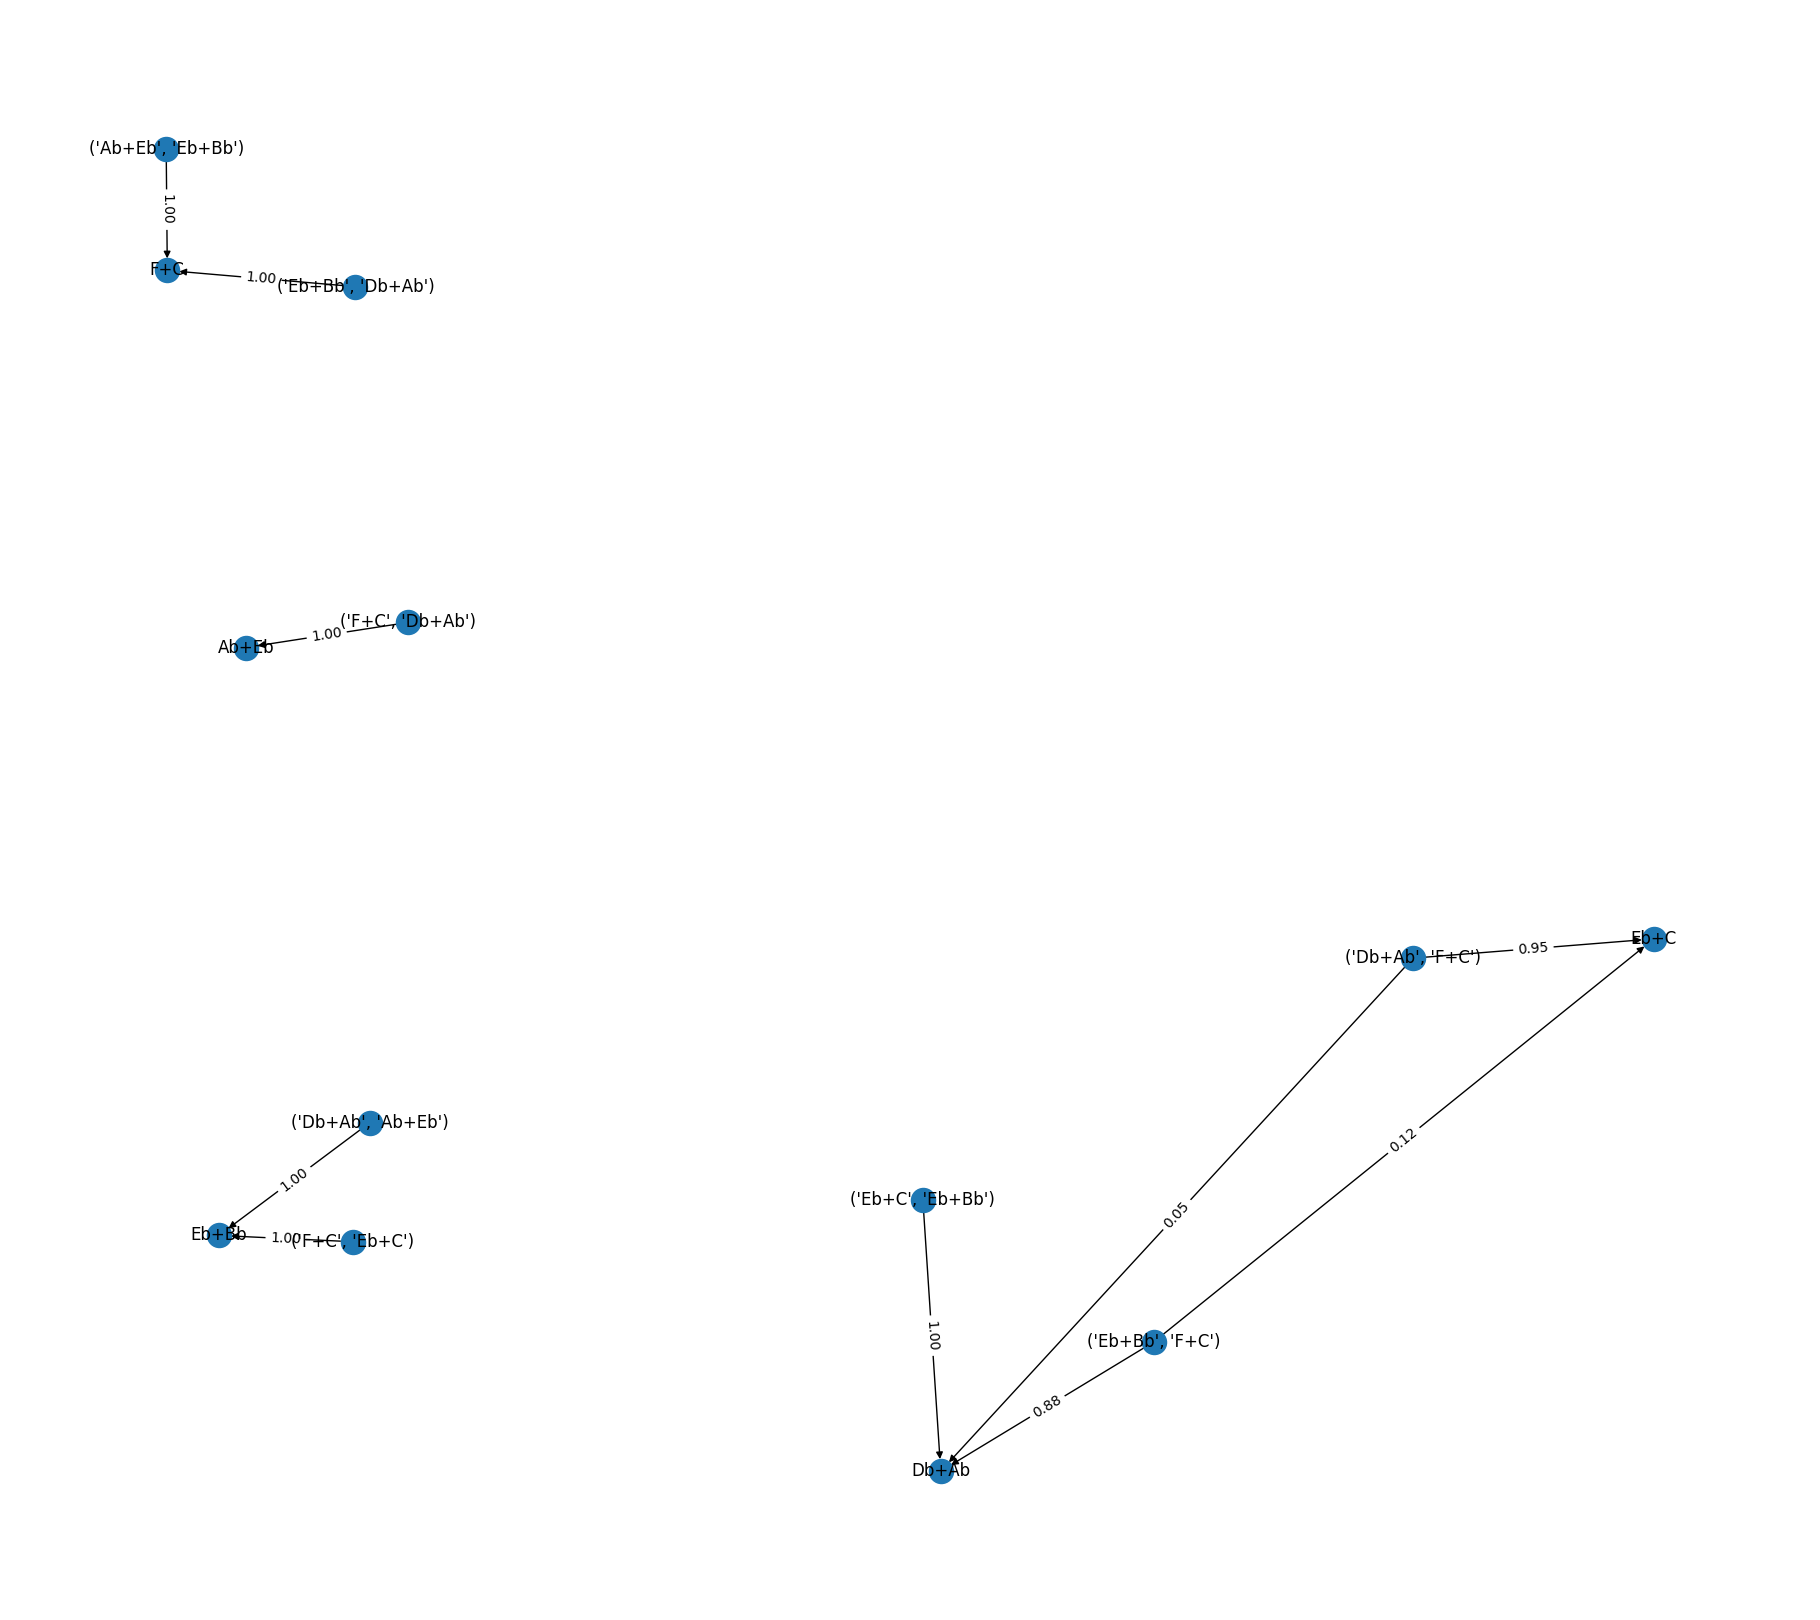

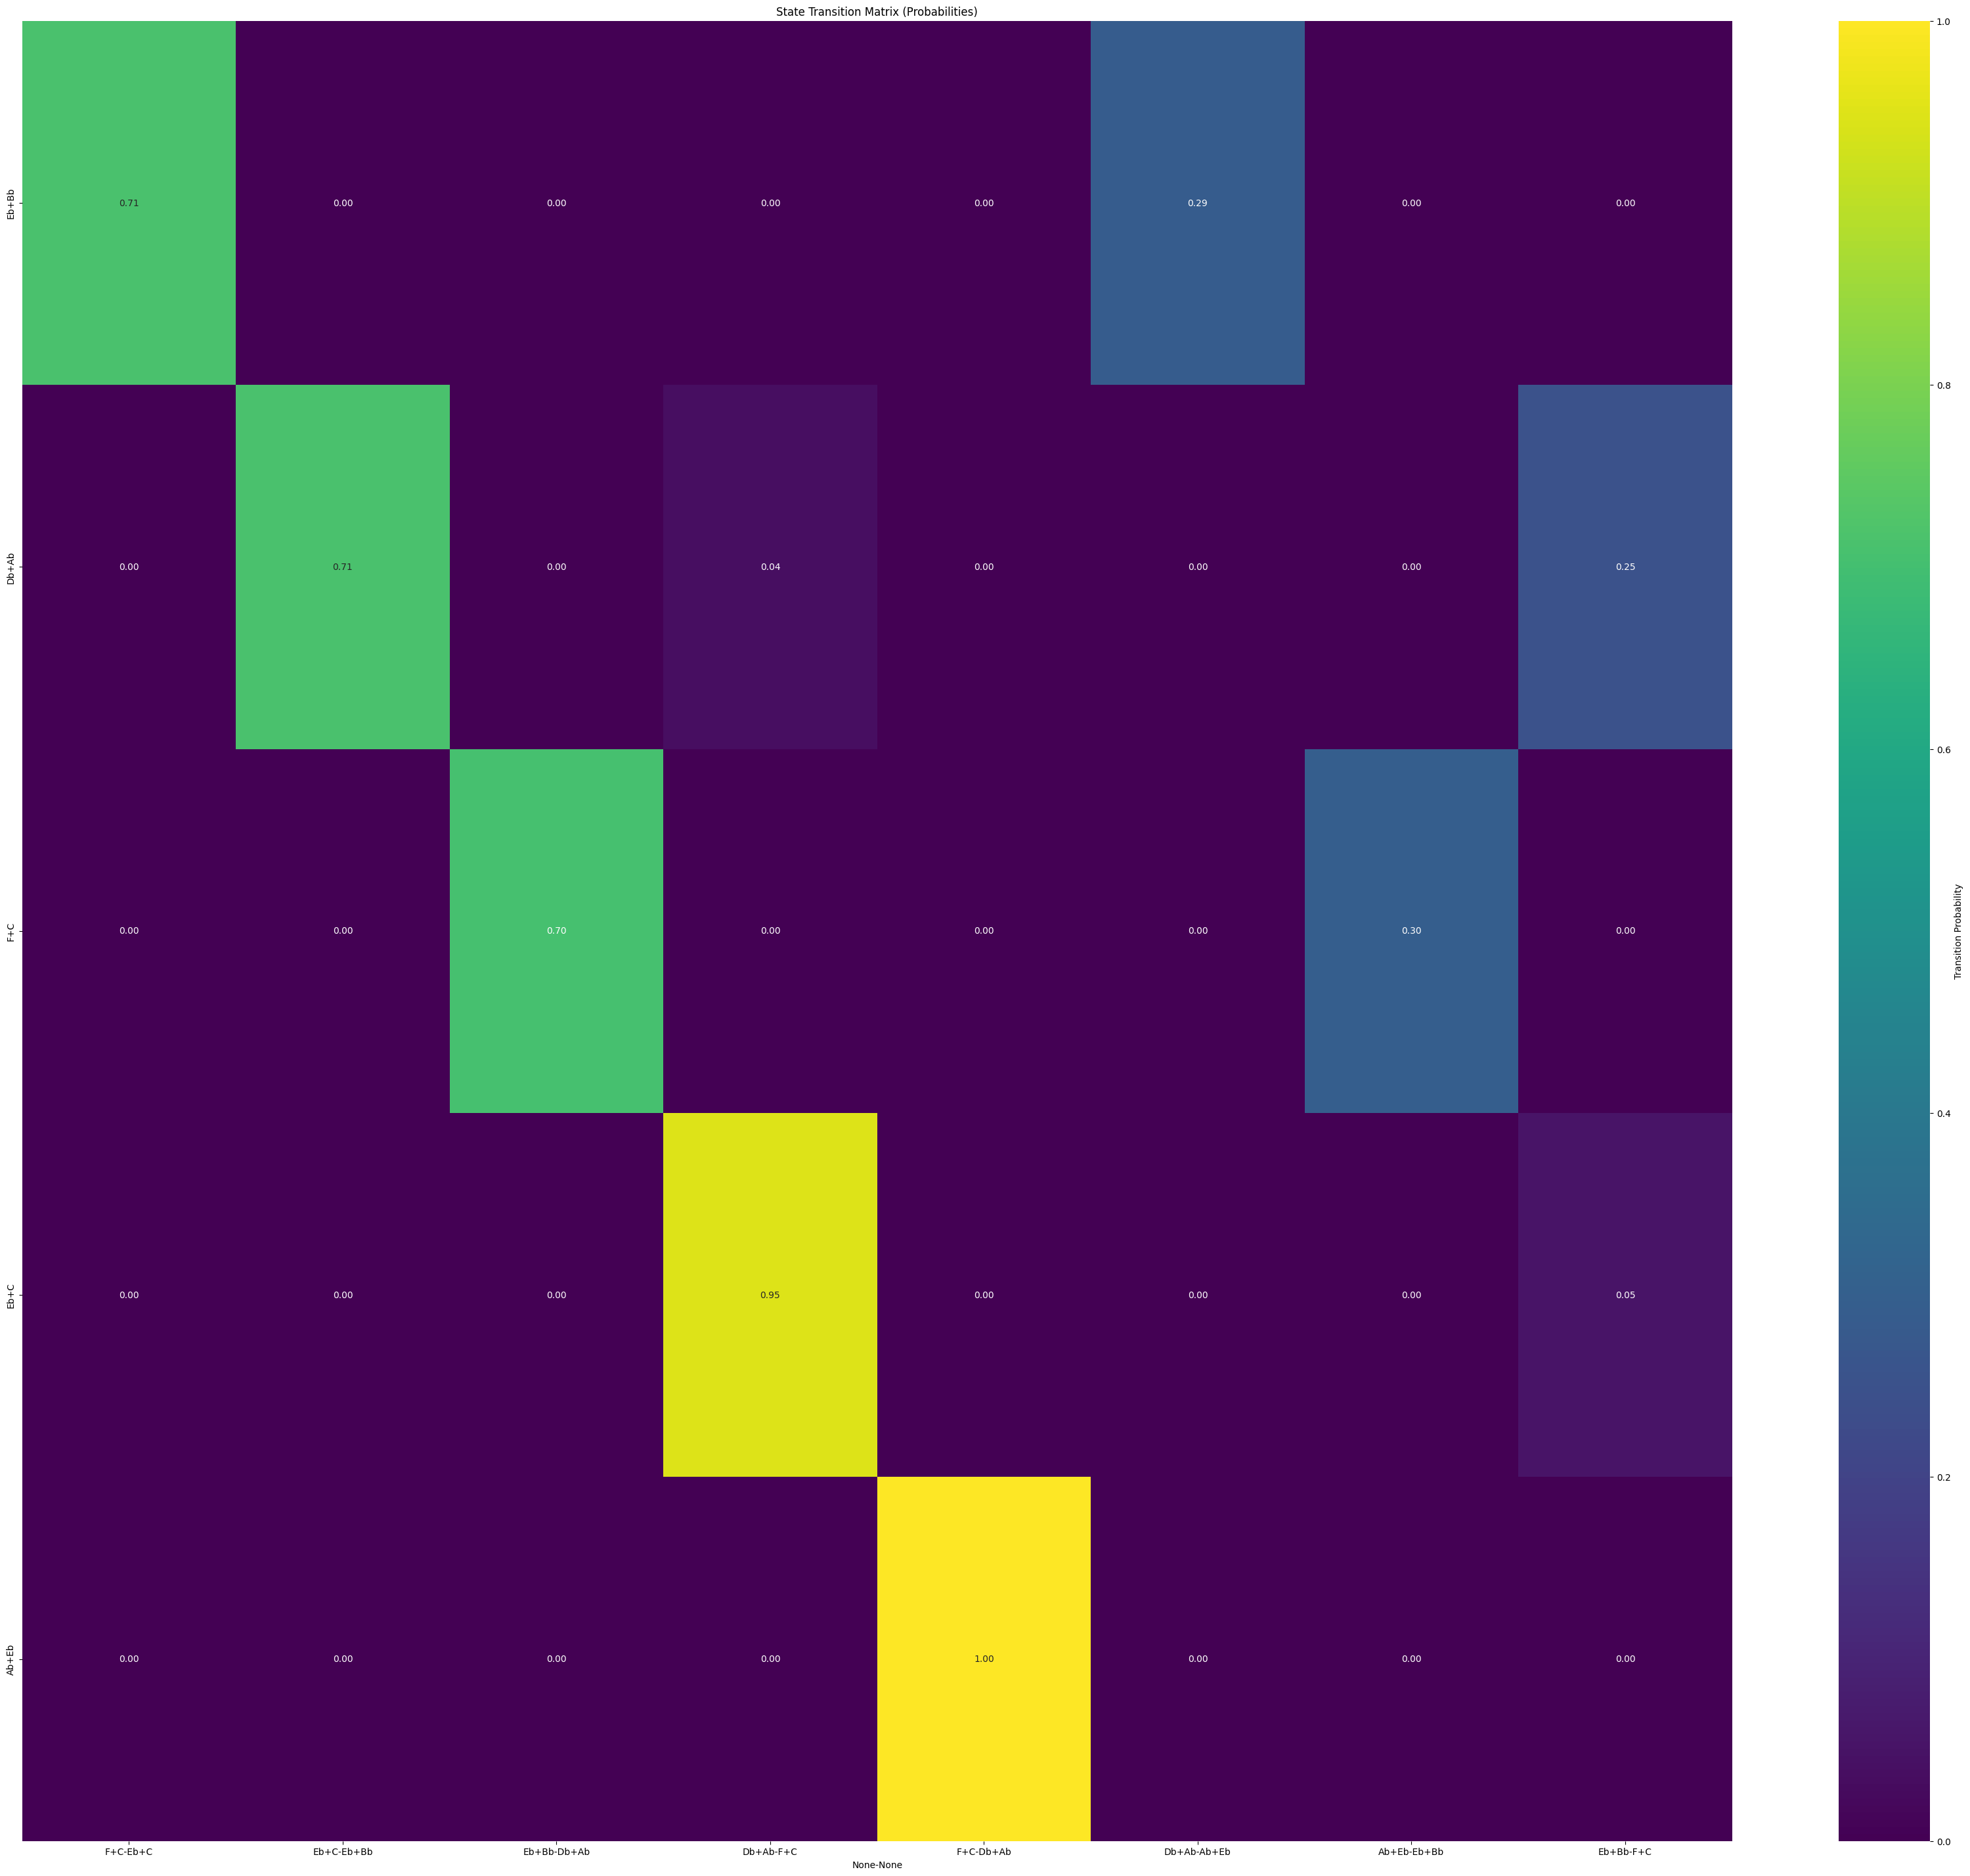

Chords in 'chord_progression.csv': ['F+C' 'Eb+C' 'Eb+Bb' 'Db+Ab' 'F+C' 'Eb+C' 'Eb+Bb' 'Db+Ab' 'F+C' 'Eb+C'
 'Eb+Bb' 'Db+Ab' 'F+C' 'Eb+C' 'Eb+Bb' 'Db+Ab' 'F+C' 'Eb+C' 'Eb+Bb' 'Db+Ab'
 'F+C' 'Eb+C' 'Eb+Bb' 'Db+Ab' 'F+C' 'Eb+C' 'Eb+Bb' 'Db+Ab' 'F+C' 'Eb+C'
 'Eb+Bb' 'Db+Ab' 'F+C' 'Eb+C' 'Eb+Bb' 'Db+Ab' 'F+C' 'Eb+C' 'Eb+Bb' 'Db+Ab'
 'F+C' 'Eb+C' 'Eb+Bb' 'Db+Ab' 'F+C' 'Db+Ab' 'Ab+Eb' 'Eb+Bb' 'F+C' 'Db+Ab'
 'Ab+Eb' 'Eb+Bb' 'F+C' 'Db+Ab' 'Ab+Eb' 'Eb+Bb' 'F+C' 'Db+Ab' 'Ab+Eb'
 'Eb+Bb' 'F+C' 'Db+Ab' 'Ab+Eb' 'Eb+Bb' 'F+C' 'Db+Ab' 'Ab+Eb' 'Eb+Bb' 'F+C'
 'Db+Ab' 'Ab+Eb' 'Eb+Bb' 'F+C' 'Db+Ab' 'Ab+Eb' 'Eb+Bb' 'F+C' 'Eb+C'
 'Eb+Bb' 'Db+Ab' 'F+C' 'Eb+C' 'Eb+Bb' 'Db+Ab' 'F+C' 'Eb+C' 'Eb+Bb' 'Db+Ab'
 'F+C' 'Eb+C' 'Eb+Bb' 'Db+Ab' 'F+C' 'Eb+C' 'Eb+Bb' 'Db+Ab' 'F+C' 'Eb+C'
 'Eb+Bb' 'Db+Ab' 'F+C' 'Eb+C' 'Eb+Bb' 'Db+Ab' 'F+C' 'Eb+C' 'Eb+Bb' 'Db+Ab'
 'F+C' 'Eb+C' 'Eb+Bb' 'Db+Ab']
N-grams: [('F+C', 'Eb+C', 'Eb+Bb'), ('Eb+C', 'Eb+Bb', 'Db+Ab'), ('Eb+Bb', 'Db+Ab', 'F+C'), ('Db+Ab', 'F+C', 'Eb+C'), ('F+C', 'Eb+C',

In [39]:
import numpy as np
import pandas as pd
from collections import Counter
!pip install midiutil
from midiutil import MIDIFile

# Define a mapping from chord names to MIDI note numbers (you may need to adjust these)
chord_mapping = {
    'C': 60,  # Adjusted to start from C4
    'C#': 61, 'C#m': 61,
    'Db': 61, 'Dbm': 61,
    'D': 62, 'Dm': 62,
    'D#': 63, 'D#m': 63,
    'Eb': 63, 'Ebm': 63,
    'E': 64, 'Em': 64,
    'F': 65, 'Fm': 65,
    'F#': 66, 'F#m': 66,
    'Gb': 66, 'Gbm': 66,
    'G': 67, 'Gm': 67,
    'G#': 68, 'G#m': 68,
    'Ab': 68, 'Abm': 68,
    'A': 69, 'Am': 69,
    'A#': 70, 'A#m': 70,
    'Bb': 70, 'Bbm': 70,
    'B': 71, 'Bm': 71,
}



def predict_next_state(chord, ngrams):
    """Predict next chord based on the current state."""
    # create list of n-grams which start with the current chord
    ngrams_with_current_chord = []
    print("Chord:", chord)
    for ngram in ngrams:
        if ngram[:-1] == chord:
            ngrams_with_current_chord.append(ngram)
    
    # count appearance of each n-gram
    count_appearance = dict(Counter(ngrams_with_current_chord))
    # convert appearance into probabilities
    for ngram in count_appearance.keys():
        count_appearance[ngram] = count_appearance[ngram] / len(ngrams_with_current_chord)
    
    # create list of possible options for the next chord
    options = [key[-1] for key in count_appearance.keys()]
    # create a list of probability distribution
    probabilities = list(count_appearance.values())
    
    # check if options is not empty before making a random choice
    if options:
        return np.random.choice(options, p=probabilities)

def generate_sequence(chord, ngrams, length: int = 30):
    """Generate a sequence of defined length."""
    # create a list to store future chords
    chords = []
    for n in range(length):
        # append the next chord to the list
        next_chord = predict_next_state(chord, ngrams)
        chords.append(next_chord)
        # use the last chord in the sequence to predict the next chord
        chord = tuple(list(chord)[1:] + [next_chord])
    
    print("Chords:", chords)  # Print the chords for debugging
    return chords

def save_as_midi(sequence, output_file="generated_sequence.mid"):
    """Save the generated sequence as a MIDI file."""
    midi = MIDIFile(1)  # 1 track
    time = 0
    tempo = 120  # BPM

    midi.addTempo(0, time, tempo)

    for chord in sequence:
        print("chord to be saved: ", chord)
        note_parts = chord.split("+")
        midi.addNote(0, 0, chord_mapping[note_parts[0]], time, 2, 50)  # Using arbitrary duration and velocity
        midi.addNote(0, 0, chord_mapping[note_parts[1]], time, 2, 50)  # Using arbitrary duration and velocity
        time+=1

    with open(output_file, "wb") as midi_file:
        midi.writeFile(midi_file)
        
def visualize_transition_matrix(ngrams):
    """Visualize the transition matrix."""
    transitions = {}
    for ngram in ngrams:
        current_state = ngram[:-1]
        next_state = ngram[-1]
        
        if current_state not in transitions:
            transitions[current_state] = {}
        
        if next_state not in transitions[current_state]:
            transitions[current_state][next_state] = 1
        else:
            transitions[current_state][next_state] += 1
    
    G = nx.DiGraph()
    for current_state, next_states in transitions.items():
        total_transitions = sum(next_states.values())
        for next_state, count in next_states.items():
            probability = count / total_transitions
            G.add_edge(current_state, next_state, weight=probability)
    
    plt.figure(figsize=(18, 16))  # Set the figure size (adjust the values as needed)
    pos = nx.spring_layout(G)
    nx.draw(G, pos, with_labels=True)
    labels = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx_edge_labels(G, pos, edge_labels={k: f"{v:.2f}" for k, v in labels.items()})
    plt.show()

def visualize_transition_matrix2(ngrams):
    transitions = {}
    for ngram in ngrams:
        current_state = ngram[:-1]
        next_state = ngram[-1]
        
        if current_state not in transitions:
            transitions[current_state] = {}
        
        if next_state not in transitions[current_state]:
            transitions[current_state][next_state] = 1
        else:
            transitions[current_state][next_state] += 1

    # Convert the dictionary to a Pandas DataFrame
    df = pd.DataFrame(transitions).fillna(0).astype(int)

    # Normalize the transition matrix to probabilities
    df_probabilities = df.div(df.sum(axis=1), axis=0)

    # Create a heatmap
    plt.figure(figsize=(42, 36))
    sns.heatmap(df_probabilities, annot=True, fmt='.2f', cmap='viridis', cbar_kws={'label': 'Transition Probability'})
    plt.title('State Transition Matrix (Probabilities)')
    plt.show()

def main():
    # read file
    # read left hand file
    data = pd.read_csv('/kaggle/input/left-right/Notes_Left.csv')
    
    
    n = 3  # considering triplets
    chords = data['chords'].values
    ngrams = zip(*[chords[i:] for i in range(n)])
    ngrams = [tuple(ngram) for ngram in ngrams]
    
    # Visualize the transition matrix
    visualize_transition_matrix(ngrams)
    visualize_transition_matrix2(ngrams)

    print("Chords in 'chord_progression.csv':", chords)
    print("N-grams:", ngrams)

    # Generate a sequence of chords
    sequence = generate_sequence(('F+C','Eb+C'), ngrams, 100)

    # Print the generated sequence
    print("Generated Sequence:", sequence)
    
    # Save the generated sequence as a MIDI file
    save_as_midi(sequence, output_file="generated_sequence_final_left.mid")

if __name__ == "__main__":
    main()



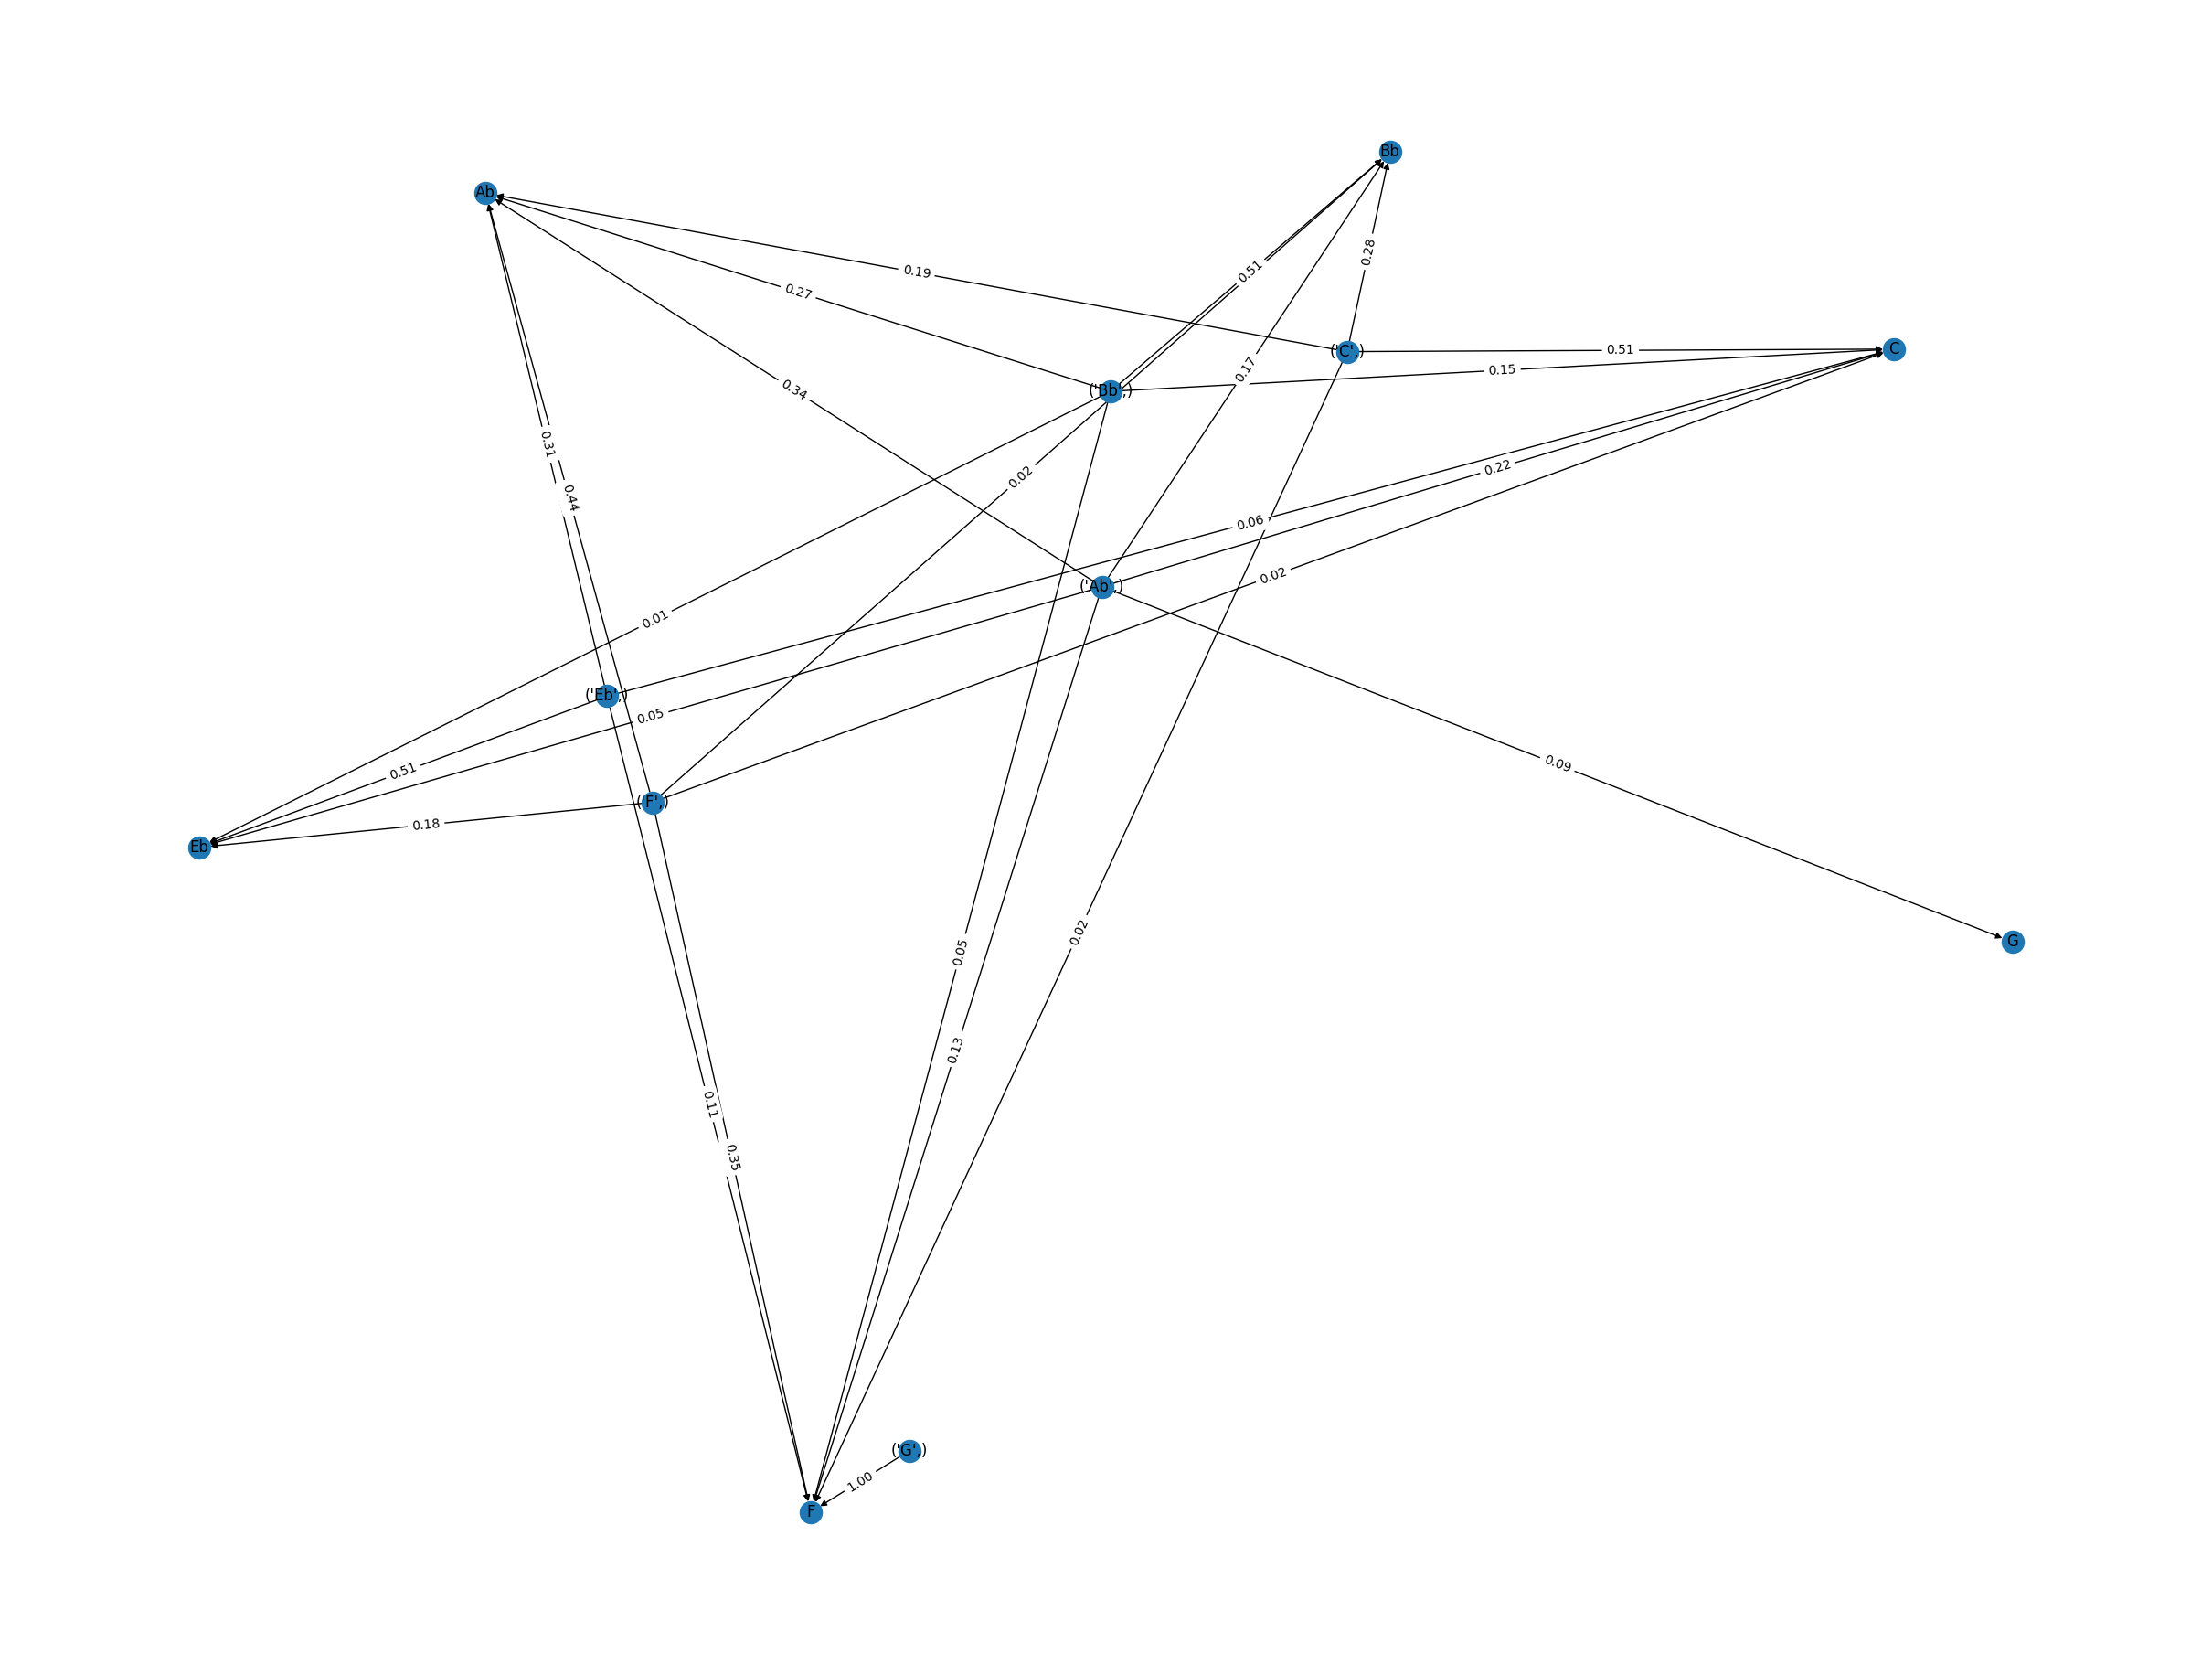

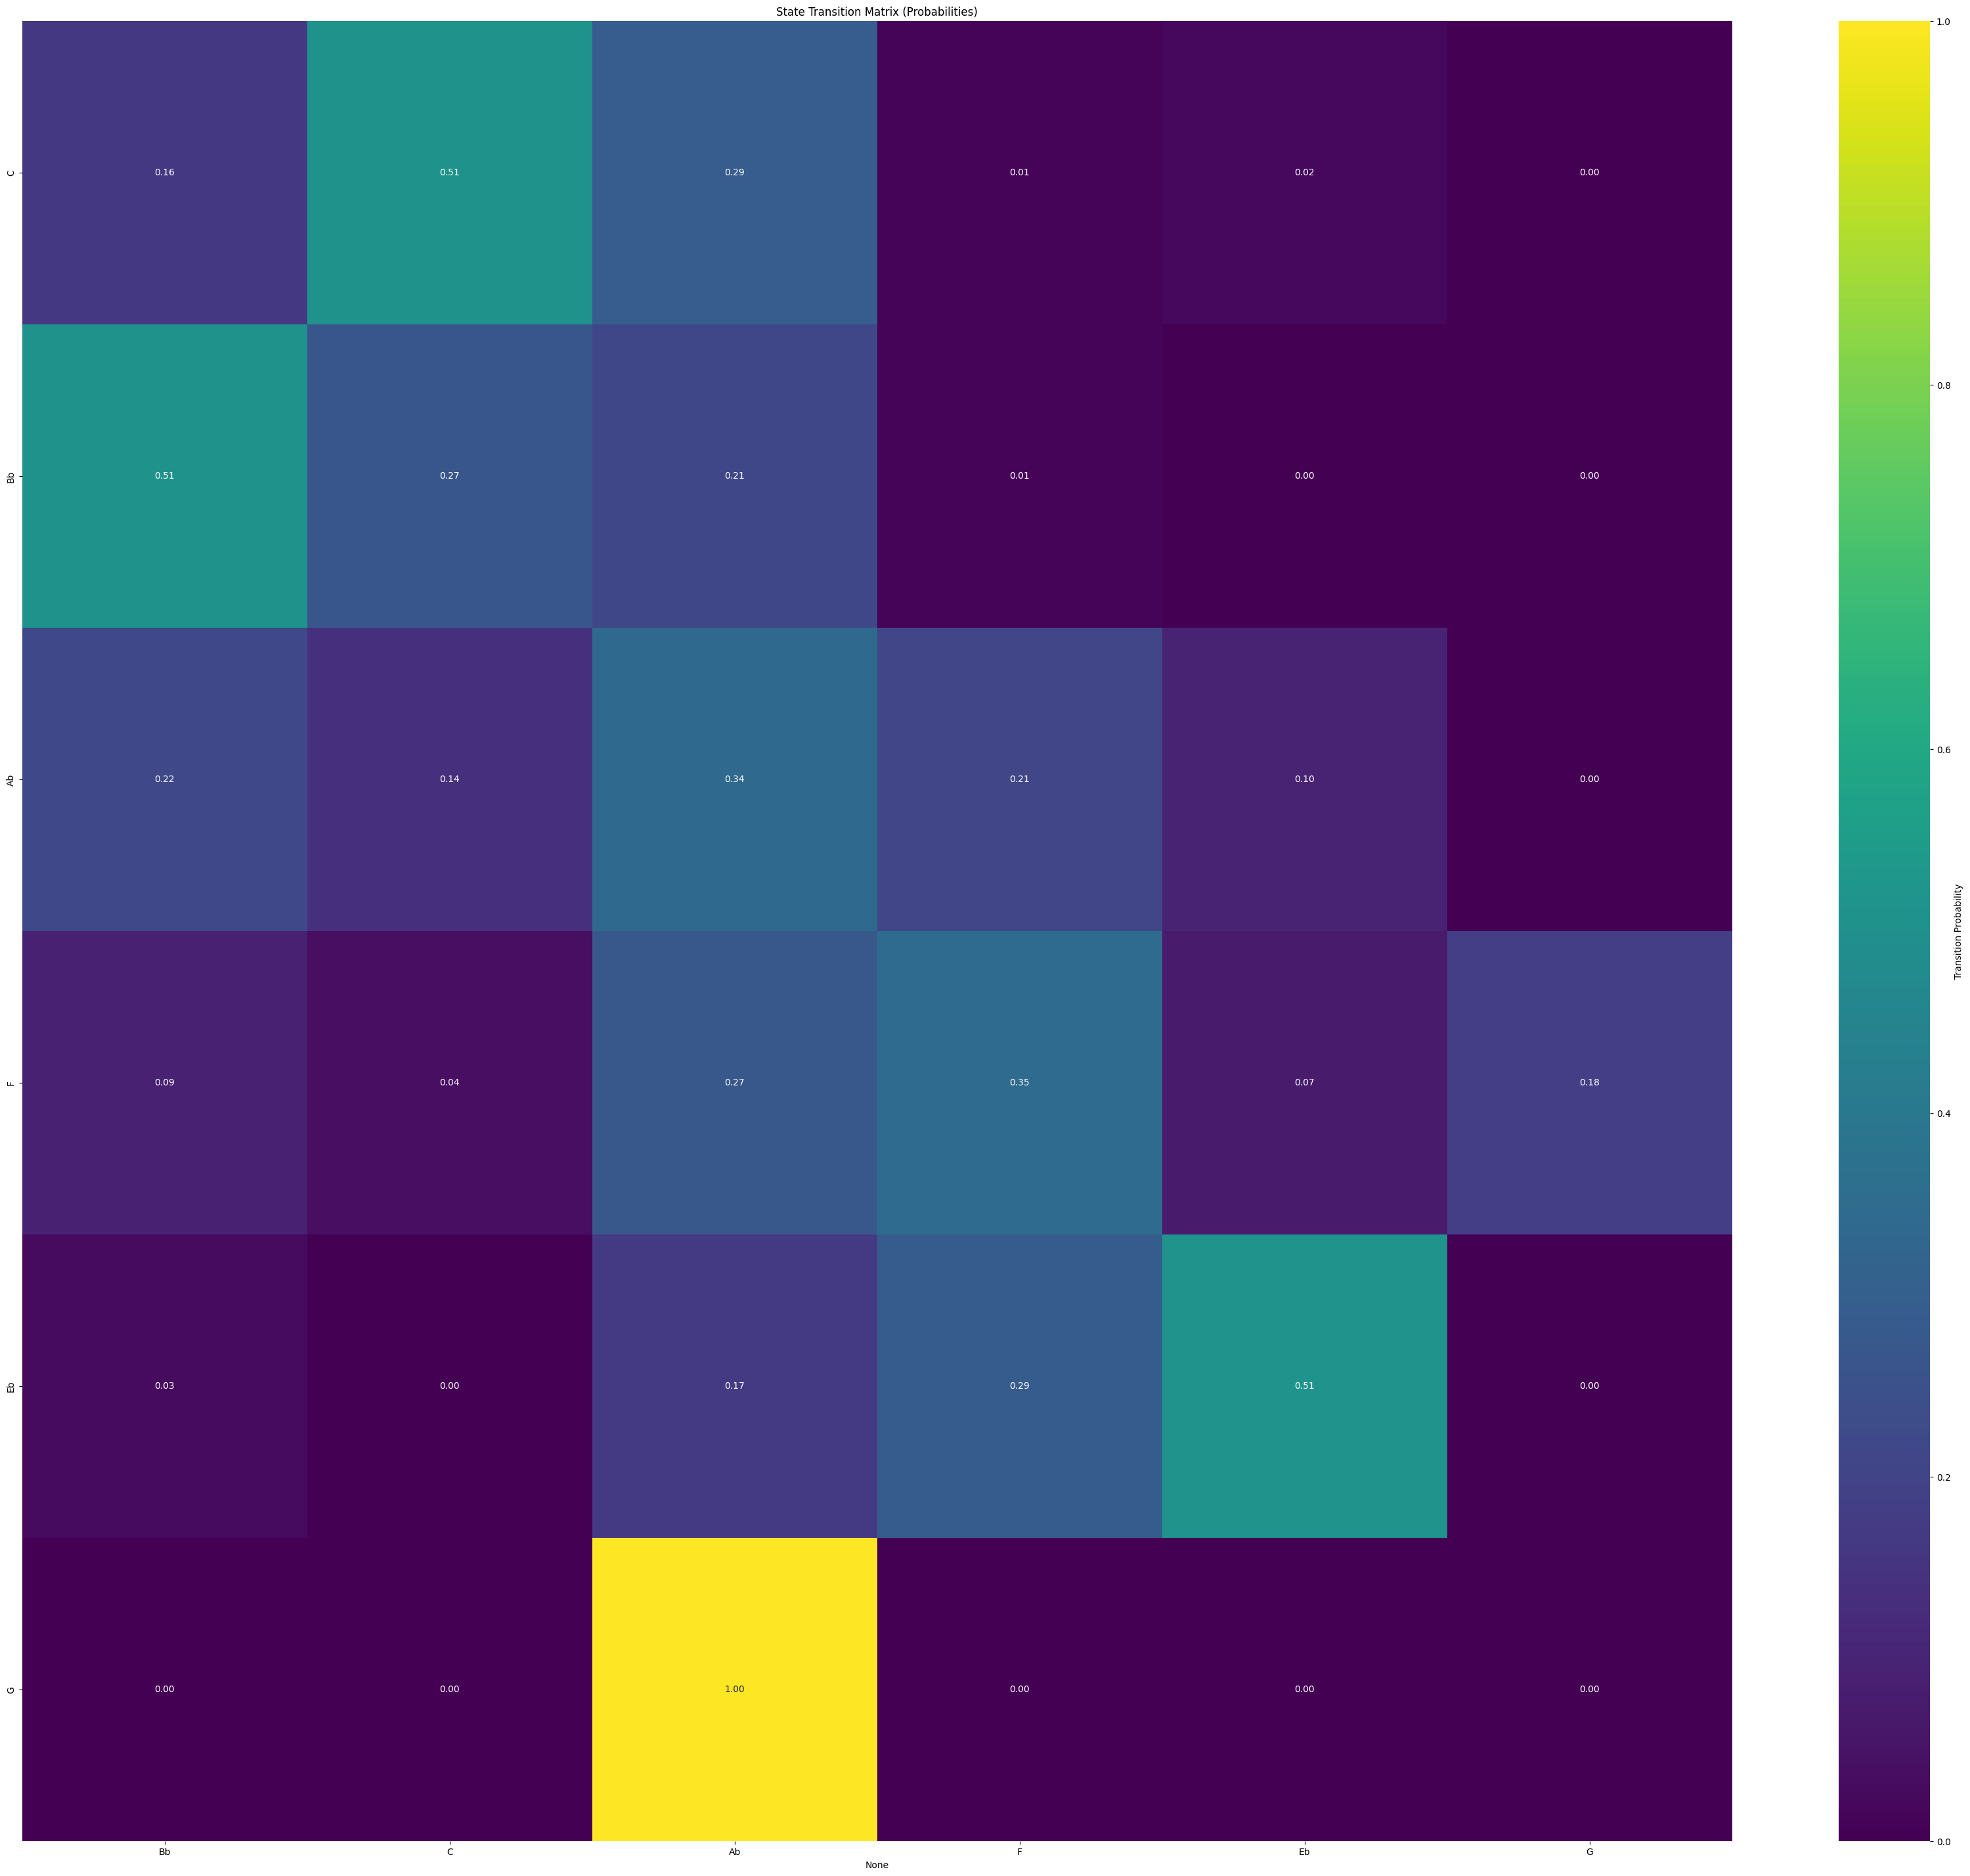

Chords in 'chord_progression.csv': ['Bb', 'C', 'Bb', 'Bb', 'Ab', 'C', 'C', 'C', 'C', 'C', 'C', 'Bb', 'Bb', 'Ab', 'Bb', 'C', 'Bb', 'F', 'Ab', 'Ab', 'C', 'C', 'Bb', 'Ab', 'Bb', 'Bb', 'Bb', 'Bb', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'Bb', 'Ab', 'Ab', 'Ab', 'Bb', 'Bb', 'Bb', 'Ab', 'Ab', 'F', 'Bb', 'C', 'Bb', 'Bb', 'Bb', 'C', 'Ab', 'C', 'C', 'C', 'C', 'C', 'C', 'Bb', 'Bb', 'Ab', 'Bb', 'C', 'Bb', 'F', 'Ab', 'Ab', 'Ab', 'C', 'C', 'Bb', 'Bb', 'Bb', 'C', 'Ab', 'C', 'C', 'C', 'C', 'C', 'C', 'Bb', 'Bb', 'Ab', 'Bb', 'C', 'Bb', 'F', 'Ab', 'Ab', 'Ab', 'C', 'C', 'Bb', 'Eb', 'Eb', 'Eb', 'C', 'C', 'Bb', 'Ab', 'Ab', 'C', 'C', 'Bb', 'Bb', 'Ab', 'Ab', 'F', 'F', 'Ab', 'Ab', 'Bb', 'Bb', 'Bb', 'Ab', 'F', 'F', 'F', 'F', 'Ab', 'Ab', 'Bb', 'Bb', 'Bb', 'Bb', 'Ab', 'Ab', 'Eb', 'Ab', 'C', 'Ab', 'C', 'Ab', 'Ab', 'Ab', 'Ab', 'G', 'F', 'Eb', 'Eb', 'Eb', 'Eb', 'Ab', 'C', 'Ab', 'F', 'Ab', 'G', 'F', 'Eb', 'F', 'F', 'F', 'Ab', 'Ab', 'Bb', 'Bb', 'Bb', 'Ab', 'C', 'C', 'C', 'C', 'Ab', 'Ab', 'Bb', 'Bb', 'Bb', 'Bb', '

In [40]:
import numpy as np
import pandas as pd
from collections import Counter
!pip install midiutil
!pip install networkx
from collections import Counter
import networkx as nx
import matplotlib.pyplot as plt

from midiutil import MIDIFile

# Define a mapping from chord names to MIDI note numbers (you may need to adjust these)
chord_mapping = {
    'C': 72,
    'C#': 73, 'C#m': 73,
    'Db': 73, 'Dbm': 73,
    'D': 74, 'Dm': 74,
    'D#': 75, 'D#m': 75,
    'Eb': 75, 'Ebm': 75,
    'E': 76, 'Em': 76,
    'F': 77, 'Fm': 77,
    'F#': 78, 'F#m': 78,
    'Gb': 78, 'Gbm': 78,
    'G': 79, 'Gm': 79,
    'G#': 80, 'G#m': 80,
    'Ab': 80, 'Abm': 80,
    'A': 81, 'Am': 81,
    'A#': 82, 'A#m': 82,
    'Bb': 82, 'Bbm': 82,
    'B': 83, 'Bm': 83,
}




def predict_next_state(chord, ngrams):
    """Predict next chord based on the current state."""
    # create list of n-grams which start with the current chord
    ngrams_with_current_chord = []
    print("Chord:", chord)
    for ngram in ngrams:
        if ngram[:-1] == chord:
            ngrams_with_current_chord.append(ngram)

    
    # count appearance of each n-gram
    count_appearance = dict(Counter(ngrams_with_current_chord))
    # convert appearance into probabilities
    for ngram in count_appearance.keys():
        count_appearance[ngram] = count_appearance[ngram] / len(ngrams_with_current_chord)
    
    # create list of possible options for the next chord
    options = [key[-1] for key in count_appearance.keys()]
    # create a list of probability distribution
    probabilities = list(count_appearance.values())
    
    # check if options is not empty before making a random choice
    if options:
        return np.random.choice(options, p=probabilities)

def generate_sequence(chord, ngrams, length: int = 30):
    """Generate a sequence of defined length."""
    # create a list to store future chords
    chords = []
    for n in range(length):
        # append the next chord to the list
        next_chord = predict_next_state(chord, ngrams)
        chords.append(next_chord)
        # use the last chord in the sequence to predict the next chord
        chord = tuple(list(chord)[1:] + [next_chord])
        # print("the chord is: ", chord)     #here
    
    print("Chords:", chords)  # Print the chords for debugging
    return chords

def save_as_midi(sequence, output_file="generated_sequence.mid"):
    """Save the generated sequence as a MIDI file."""
    midi = MIDIFile(1)  # 1 track
    time = 0
    tempo = 120  # BPM

    midi.addTempo(0, time, tempo)

    for chord in sequence:
        print("chord to be saved: ", chord)
        midi.addNote(0, 0, chord_mapping[chord], time, 0.5, 80)  # Using arbitrary duration and velocity
        time+=1

    with open(output_file, "wb") as midi_file:
        midi.writeFile(midi_file)
        
def visualize_transition_matrix(ngrams):
    """Visualize the transition matrix."""
    transitions = {}
    for ngram in ngrams:
        current_state = ngram[:-1]
        next_state = ngram[-1]
        
        if current_state not in transitions:
            transitions[current_state] = {}
        
        if next_state not in transitions[current_state]:
            transitions[current_state][next_state] = 1
        else:
            transitions[current_state][next_state] += 1
    
    G = nx.DiGraph()
    for current_state, next_states in transitions.items():
        total_transitions = sum(next_states.values())
        for next_state, count in next_states.items():
            probability = count / total_transitions
            G.add_edge(current_state, next_state, weight=probability)
    
    plt.figure(figsize=(24, 18))  # Set the figure size (adjust the values as needed)
    pos = nx.spring_layout(G)
    nx.draw(G, pos, with_labels=True)
    labels = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx_edge_labels(G, pos, edge_labels={k: f"{v:.2f}" for k, v in labels.items()})
    plt.show()

def visualize_transition_matrix2(ngrams):
    transitions = {}
    for ngram in ngrams:
        current_state = ngram[:-1]
        next_state = ngram[-1]
        
        if current_state not in transitions:
            transitions[current_state] = {}
        
        if next_state not in transitions[current_state]:
            transitions[current_state][next_state] = 1
        else:
            transitions[current_state][next_state] += 1

    # Convert the dictionary to a Pandas DataFrame
    df = pd.DataFrame(transitions).fillna(0).astype(int)

    # Normalize the transition matrix to probabilities
    df_probabilities = df.div(df.sum(axis=1), axis=0)

    # Create a heatmap
    plt.figure(figsize=(42, 36))
    sns.heatmap(df_probabilities, annot=True, fmt='.2f', cmap='viridis', cbar_kws={'label': 'Transition Probability'})
    plt.title('State Transition Matrix (Probabilities)')
    plt.show()


def main():
    # read file
    
    # read right hand file
    # data = pd.read_csv('/kaggle/input/left-right/Notes_Right.csv')

    data = {'chords' : ['Bb', 'C', 'Bb', 'Bb', 'Ab', 'C', 'C', 'C', 'C', 'C', 'C', 'Bb', 'Bb', 'Ab', 'Bb', 'C', 'Bb', 'F', 'Ab', 'Ab', 'C', 'C', 'Bb', 'Ab', 'Bb', 'Bb', 'Bb', 'Bb', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'Bb', 'Ab', 'Ab', 'Ab', 'Bb', 'Bb', 'Bb', 'Ab', 'Ab', 'F', 'Bb', 'C', 'Bb', 'Bb', 'Bb', 'C', 'Ab', 'C', 'C', 'C', 'C', 'C', 'C', 'Bb', 'Bb', 'Ab', 'Bb', 'C', 'Bb', 'F', 'Ab', 'Ab', 'Ab', 'C', 'C', 'Bb', 'Bb', 'Bb', 'C', 'Ab', 'C', 'C', 'C', 'C', 'C', 'C', 'Bb', 'Bb', 'Ab', 'Bb', 'C', 'Bb', 'F', 'Ab', 'Ab', 'Ab', 'C', 'C', 'Bb', 'Eb', 'Eb', 'Eb', 'C', 'C', 'Bb', 'Ab', 'Ab', 'C', 'C', 'Bb', 'Bb', 'Ab', 'Ab', 'F', 'F', 'Ab', 'Ab', 'Bb', 'Bb', 'Bb', 'Ab', 'F', 'F', 'F', 'F', 'Ab', 'Ab', 'Bb', 'Bb', 'Bb', 'Bb', 'Ab', 'Ab', 'Eb', 'Ab', 'C', 'Ab', 'C', 'Ab', 'Ab', 'Ab', 'Ab', 'G', 'F', 'Eb', 'Eb', 'Eb', 'Eb', 'Ab', 'C', 'Ab', 'F', 'Ab', 'G', 'F', 'Eb', 'F', 'F', 'F', 'Ab', 'Ab', 'Bb', 'Bb', 'Bb', 'Ab', 'C', 'C', 'C', 'C', 'Ab', 'Ab', 'Bb', 'Bb', 'Bb', 'Bb', 'Ab', 'Ab', 'Eb', 'Ab', 'C', 'Ab', 'F', 'Ab', 'Ab', 'G', 'F', 'Eb', 'Eb', 'Eb', 'Eb', 'Ab', 'C', 'Ab', 'F', 'Ab', 'G', 'F', 'Eb', 'F', 'F', 'F', 'Ab', 'Ab', 'Bb', 'Bb', 'Bb', 'Ab', 'C', 'F', 'F', 'F', 'Ab', 'Ab', 'Bb', 'Bb', 'Bb', 'Bb', 'Ab', 'Ab', 'Eb', 'Ab', 'C', 'Ab', 'F', 'Ab', 'Ab', 'Ab', 'Ab', 'G', 'F', 'Eb', 'Eb', 'Eb', 'Eb', 'Ab', 'C', 'Ab', 'F', 'Ab', 'G', 'F', 'Eb', 'F', 'F', 'C', 'Bb', 'Ab', 'Bb', 'C', 'Bb', 'Bb', 'C', 'Ab', 'C', 'C', 'C', 'C', 'C', 'C', 'Bb', 'Bb', 'Ab', 'Bb', 'C', 'Bb', 'F', 'Ab', 'Bb', 'C', 'Bb', 'Bb', 'Bb', 'Bb', 'C', 'Ab', 'C', 'C', 'C', 'C', 'C', 'C', 'Bb', 'Bb', 'Ab', 'Bb', 'C', 'Bb', 'F', 'Ab', 'F', 'Ab', 'C', 'C', 'Bb', 'Ab', 'Eb', 'Eb', 'C', 'C', 'Bb', 'Ab', 'C', 'C', 'Bb', 'Bb', 'Ab', 'Ab', 'F', 'F', 'Ab', 'Ab', 'Bb', 'Bb', 'Bb', 'Ab', 'F', 'F', 'F', 'F', 'Ab', 'Ab', 'Bb', 'Bb', 'Bb', 'Bb', 'Ab', 'Ab', 'Eb', 'Ab', 'C', 'Ab', 'F', 'Ab', 'Ab', 'Ab', 'Ab', 'G', 'F', 'Eb', 'Eb', 'Eb', 'Eb', 'Ab', 'C', 'Ab', 'F', 'Ab', 'G', 'F', 'Eb', 'F', 'F', 'F', 'Ab', 'Ab', 'Bb', 'Bb', 'Bb', 'Ab', 'C', 'F', 'F', 'F', 'Ab', 'Ab', 'Bb', 'Bb', 'Bb', 'Bb', 'Ab', 'Ab', 'Eb', 'Ab', 'C', 'Ab', 'F', 'Ab', 'Ab', 'G', 'F', 'Eb', 'Eb', 'Eb', 'Eb', 'Ab', 'C', 'Ab', 'F', 'Ab', 'Ab', 'Ab', 'G', 'F', 'Eb', 'Ab']}
    
    
    n = 2  # considering doublets
    # chords = data['chords'].values
    chords = data['chords']
    ngrams = zip(*[chords[i:] for i in range(n)])
    ngrams = [tuple(ngram) for ngram in ngrams]
    
    # Visualize the transition matrix
    visualize_transition_matrix(ngrams)
    visualize_transition_matrix2(ngrams)

    print("Chords in 'chord_progression.csv':", chords)
    print("N-grams:", ngrams)

    # Generate a sequence of chords
    sequence = generate_sequence(('Bb',), ngrams, 100)

    # Print the generated sequence
    print("Generated Sequence:", sequence)
    
    # Save the generated sequence as a MIDI file
    save_as_midi(sequence, output_file="generated_sequence_final_right_Simple_MC.mid")

if __name__ == "__main__":
    main()

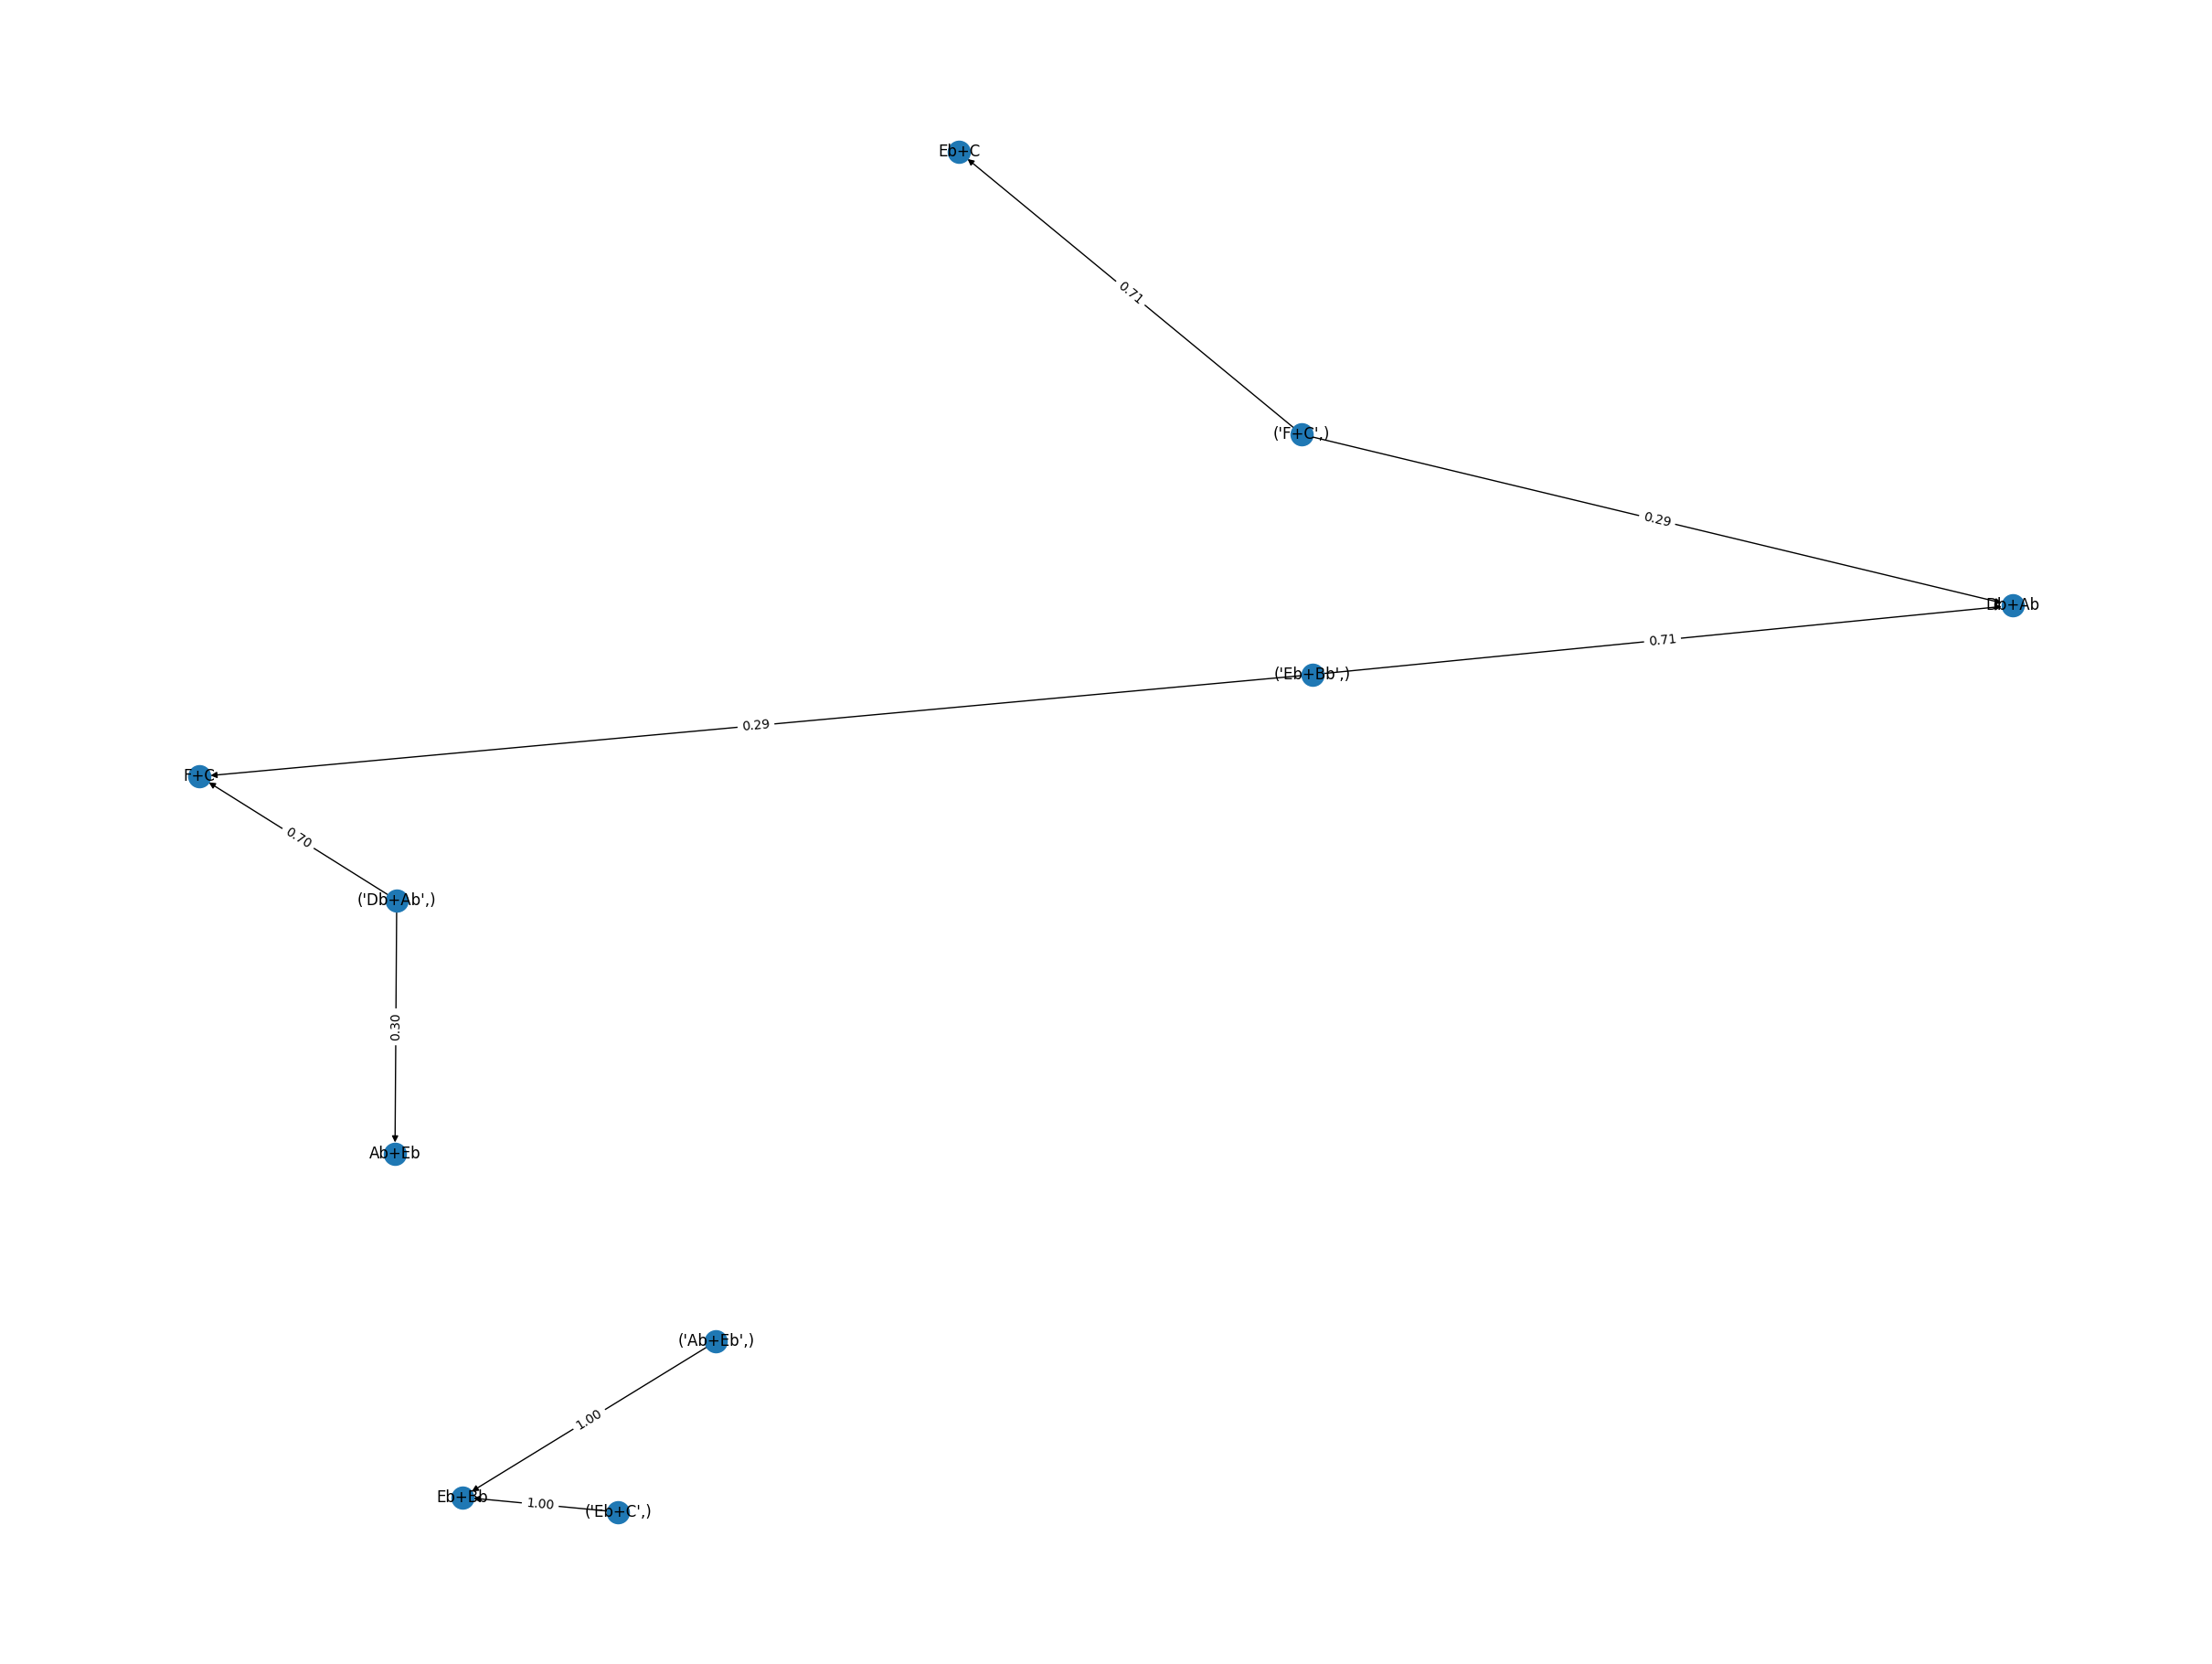

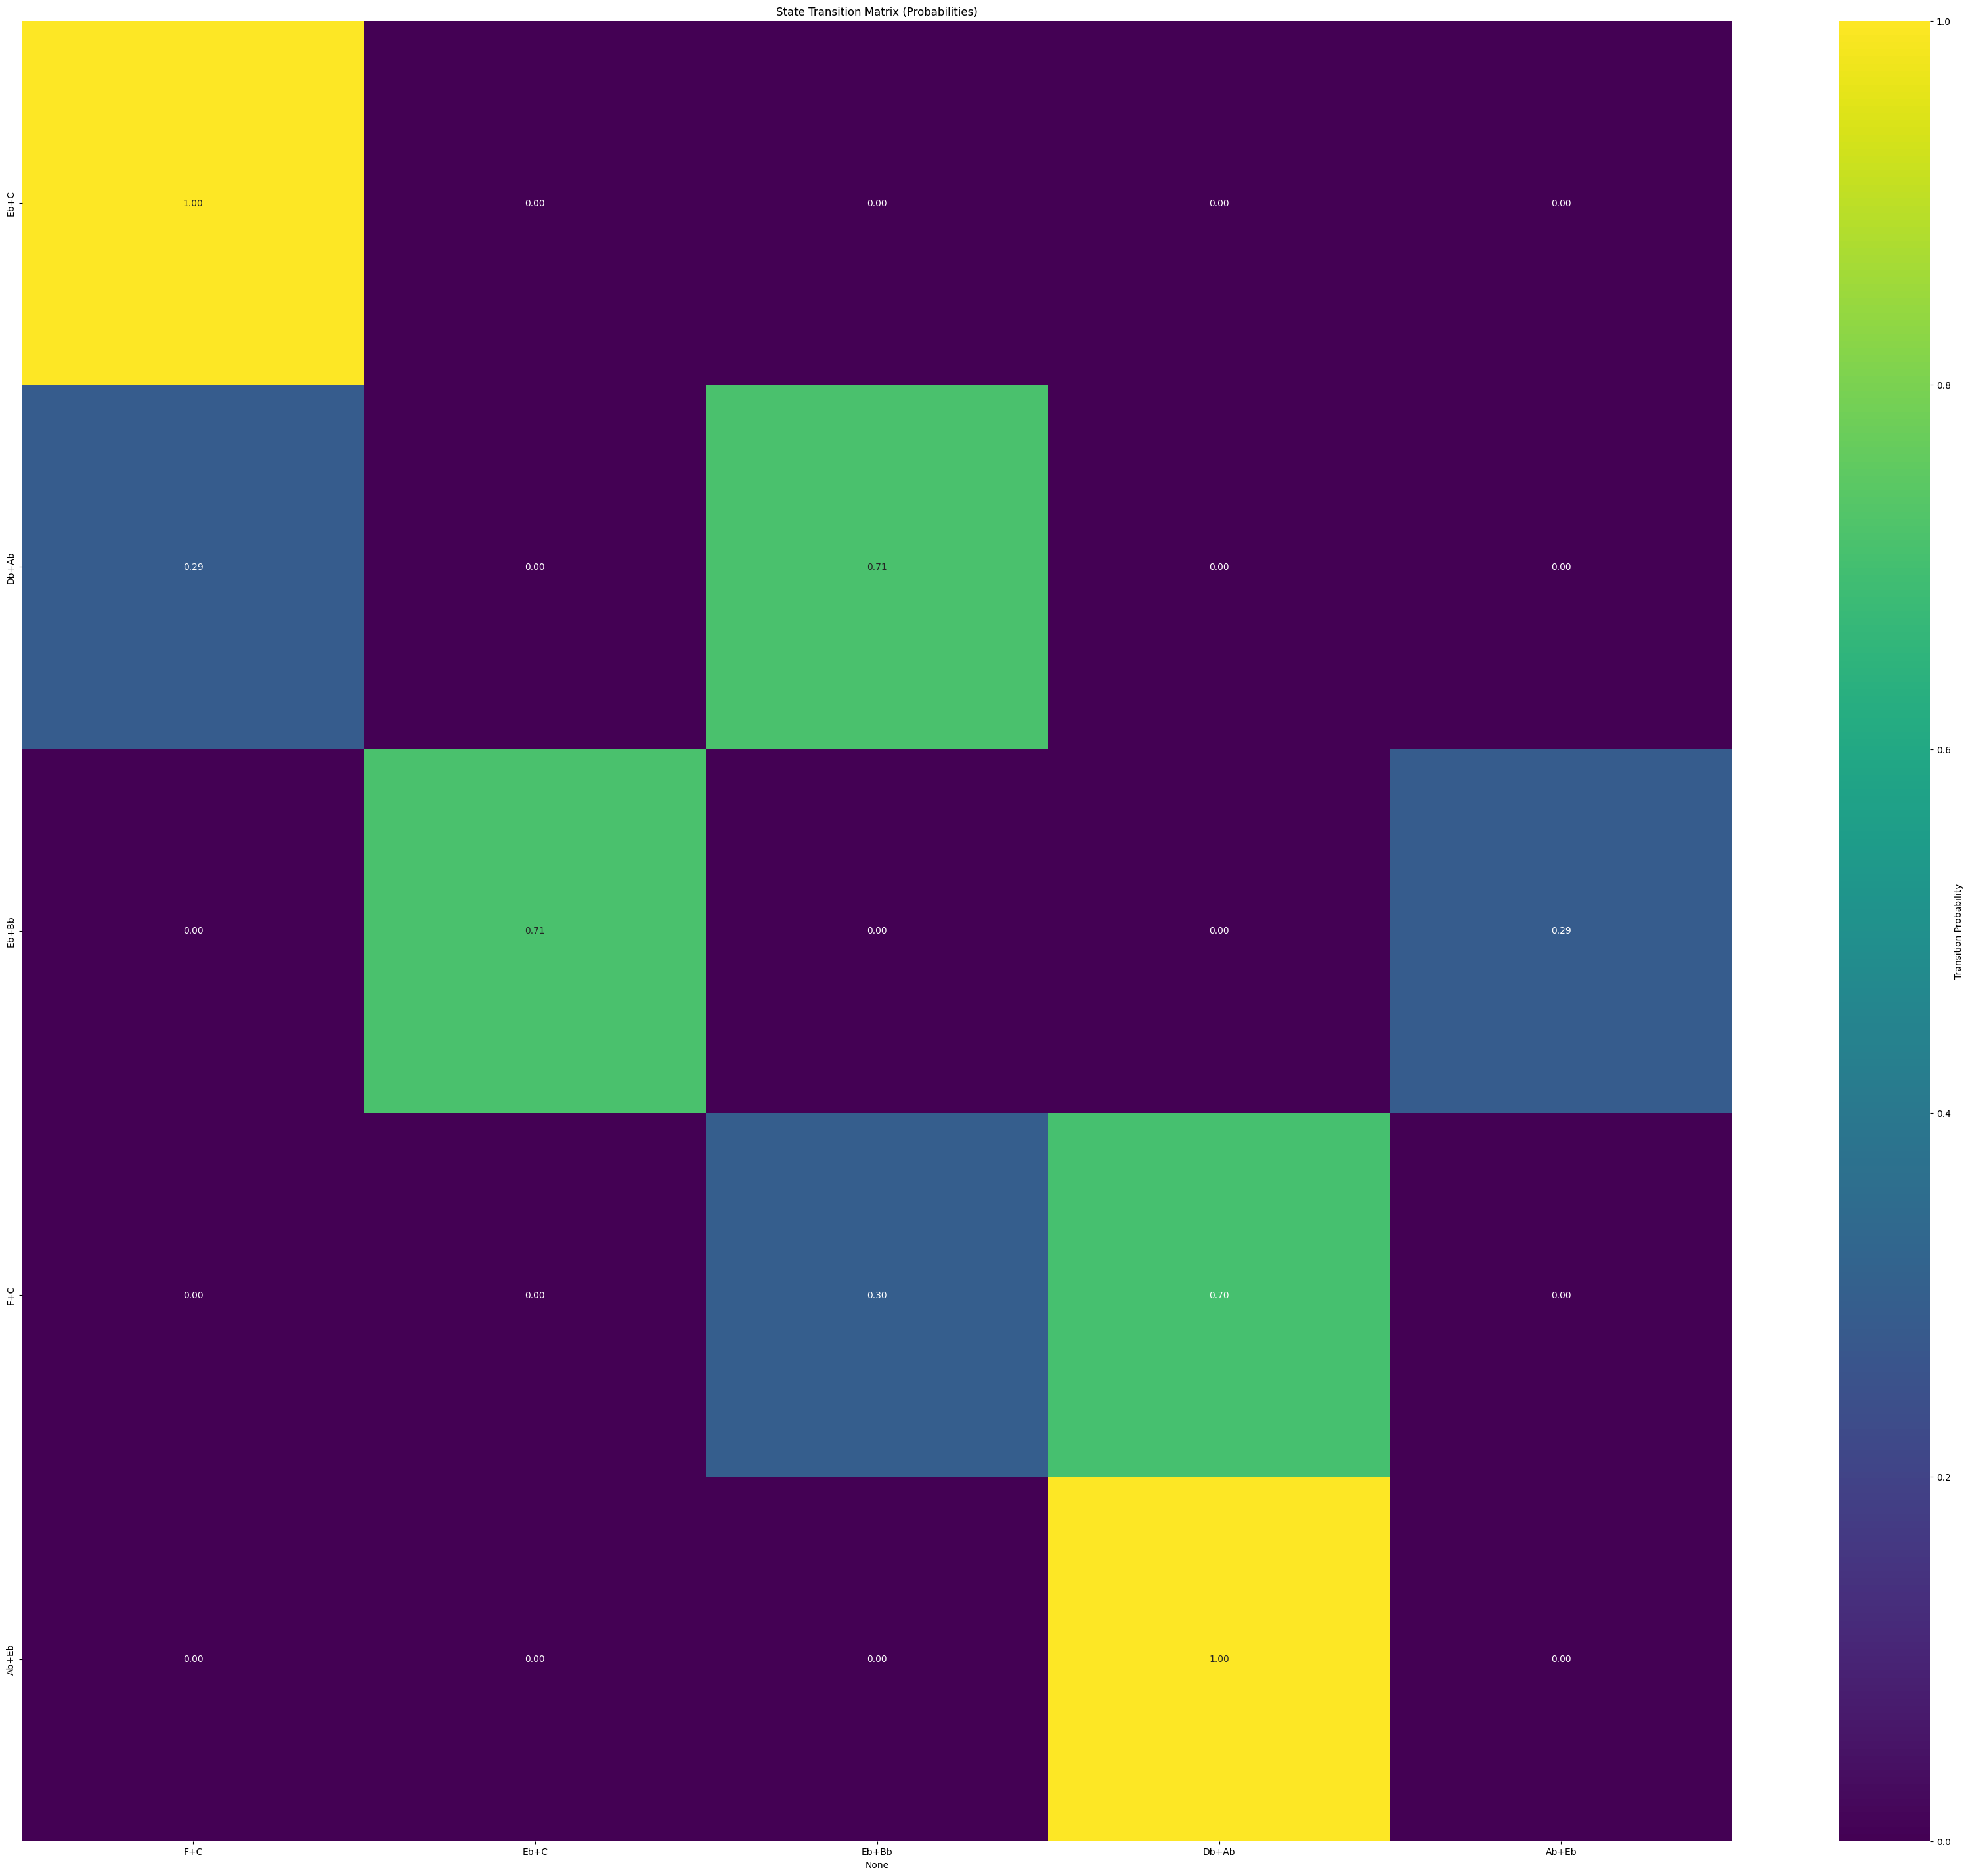

Chords in 'chord_progression.csv': ['F+C', 'Eb+C', 'Eb+Bb', 'Db+Ab', 'F+C', 'Eb+C', 'Eb+Bb', 'Db+Ab', 'F+C', 'Eb+C', 'Eb+Bb', 'Db+Ab', 'F+C', 'Eb+C', 'Eb+Bb', 'Db+Ab', 'F+C', 'Eb+C', 'Eb+Bb', 'Db+Ab', 'F+C', 'Eb+C', 'Eb+Bb', 'Db+Ab', 'F+C', 'Eb+C', 'Eb+Bb', 'Db+Ab', 'F+C', 'Eb+C', 'Eb+Bb', 'Db+Ab', 'F+C', 'Eb+C', 'Eb+Bb', 'Db+Ab', 'F+C', 'Eb+C', 'Eb+Bb', 'Db+Ab', 'F+C', 'Eb+C', 'Eb+Bb', 'Db+Ab', 'F+C', 'Db+Ab', 'Ab+Eb', 'Eb+Bb', 'F+C', 'Db+Ab', 'Ab+Eb', 'Eb+Bb', 'F+C', 'Db+Ab', 'Ab+Eb', 'Eb+Bb', 'F+C', 'Db+Ab', 'Ab+Eb', 'Eb+Bb', 'F+C', 'Db+Ab', 'Ab+Eb', 'Eb+Bb', 'F+C', 'Db+Ab', 'Ab+Eb', 'Eb+Bb', 'F+C', 'Db+Ab', 'Ab+Eb', 'Eb+Bb', 'F+C', 'Db+Ab', 'Ab+Eb', 'Eb+Bb', 'F+C', 'Eb+C', 'Eb+Bb', 'Db+Ab', 'F+C', 'Eb+C', 'Eb+Bb', 'Db+Ab', 'F+C', 'Eb+C', 'Eb+Bb', 'Db+Ab', 'F+C', 'Eb+C', 'Eb+Bb', 'Db+Ab', 'F+C', 'Eb+C', 'Eb+Bb', 'Db+Ab', 'F+C', 'Eb+C', 'Eb+Bb', 'Db+Ab', 'F+C', 'Eb+C', 'Eb+Bb', 'Db+Ab', 'F+C', 'Eb+C', 'Eb+Bb', 'Db+Ab', 'F+C', 'Eb+C', 'Eb+Bb', 'Db+Ab']
N-grams: [('F+C', 'Eb+C'), ('Eb+

In [41]:
import numpy as np
import pandas as pd
from collections import Counter
!pip install midiutil
from midiutil import MIDIFile

# Define a mapping from chord names to MIDI note numbers (you may need to adjust these)
chord_mapping = {
    'C': 60,  # Adjusted to start from C4
    'C#': 61, 'C#m': 61,
    'Db': 61, 'Dbm': 61,
    'D': 62, 'Dm': 62,
    'D#': 63, 'D#m': 63,
    'Eb': 63, 'Ebm': 63,
    'E': 64, 'Em': 64,
    'F': 65, 'Fm': 65,
    'F#': 66, 'F#m': 66,
    'Gb': 66, 'Gbm': 66,
    'G': 67, 'Gm': 67,
    'G#': 68, 'G#m': 68,
    'Ab': 68, 'Abm': 68,
    'A': 69, 'Am': 69,
    'A#': 70, 'A#m': 70,
    'Bb': 70, 'Bbm': 70,
    'B': 71, 'Bm': 71,
}



def predict_next_state(chord, ngrams):
    """Predict next chord based on the current state."""
    # create list of n-grams which start with the current chord
    ngrams_with_current_chord = []
    print("Chord:", chord)
    for ngram in ngrams:
        if ngram[:-1] == chord:
            ngrams_with_current_chord.append(ngram)

    
    # count appearance of each n-gram
    count_appearance = dict(Counter(ngrams_with_current_chord))
    # convert appearance into probabilities
    for ngram in count_appearance.keys():
        count_appearance[ngram] = count_appearance[ngram] / len(ngrams_with_current_chord)
    
    # create list of possible options for the next chord
    options = [key[-1] for key in count_appearance.keys()]
    # create a list of probability distribution
    probabilities = list(count_appearance.values())
    
    # check if options is not empty before making a random choice
    if options:
        return np.random.choice(options, p=probabilities)

def generate_sequence(chord, ngrams, length: int = 30):
    """Generate a sequence of defined length."""
    # create a list to store future chords
    chords = []
    for n in range(length):
        # append the next chord to the list
        next_chord = predict_next_state(chord, ngrams)
        chords.append(next_chord)
        # use the last chord in the sequence to predict the next chord
        chord = tuple(list(chord)[1:] + [next_chord])
    
    print("Chords:", chords)  # Print the chords for debugging
    return chords

def save_as_midi(sequence, output_file="generated_sequence.mid"):
    """Save the generated sequence as a MIDI file."""
    midi = MIDIFile(1)  # 1 track
    time = 0
    tempo = 120  # BPM

    midi.addTempo(0, time, tempo)

    for chord in sequence:
        print("chord to be saved: ", chord)
        note_parts = chord.split("+")
        midi.addNote(0, 0, chord_mapping[note_parts[0]], time, 2, 50)  # Using arbitrary duration and velocity
        midi.addNote(0, 0, chord_mapping[note_parts[1]], time, 2, 50)  # Using arbitrary duration and velocity
        time+=1

    with open(output_file, "wb") as midi_file:
        midi.writeFile(midi_file)
        
def visualize_transition_matrix(ngrams):
    """Visualize the transition matrix."""
    transitions = {}
    for ngram in ngrams:
        current_state = ngram[:-1]
        next_state = ngram[-1]
        
        if current_state not in transitions:
            transitions[current_state] = {}
        
        if next_state not in transitions[current_state]:
            transitions[current_state][next_state] = 1
        else:
            transitions[current_state][next_state] += 1
    
    G = nx.DiGraph()
    for current_state, next_states in transitions.items():
        total_transitions = sum(next_states.values())
        for next_state, count in next_states.items():
            probability = count / total_transitions
            G.add_edge(current_state, next_state, weight=probability)
    
    plt.figure(figsize=(24, 18))  # Set the figure size (adjust the values as needed)
    pos = nx.spring_layout(G)
    nx.draw(G, pos, with_labels=True)
    labels = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx_edge_labels(G, pos, edge_labels={k: f"{v:.2f}" for k, v in labels.items()})
    plt.show()

def visualize_transition_matrix2(ngrams):
    transitions = {}
    for ngram in ngrams:
        current_state = ngram[:-1]
        next_state = ngram[-1]
        
        if current_state not in transitions:
            transitions[current_state] = {}
        
        if next_state not in transitions[current_state]:
            transitions[current_state][next_state] = 1
        else:
            transitions[current_state][next_state] += 1

    # Convert the dictionary to a Pandas DataFrame
    df = pd.DataFrame(transitions).fillna(0).astype(int)

    # Normalize the transition matrix to probabilities
    df_probabilities = df.div(df.sum(axis=1), axis=0)

    # Create a heatmap
    plt.figure(figsize=(42, 36))
    sns.heatmap(df_probabilities, annot=True, fmt='.2f', cmap='viridis', cbar_kws={'label': 'Transition Probability'})
    plt.title('State Transition Matrix (Probabilities)')
    plt.show()

def main():
    # read file
    # read left hand file
    # data = pd.read_csv('/kaggle/input/left-right/Notes_Left.csv')
    
    
    n = 2  # considering triplets
    # chords = data['chords'].values
    chords = ['F+C', 'Eb+C', 'Eb+Bb', 'Db+Ab', 'F+C', 'Eb+C', 'Eb+Bb', 'Db+Ab', 'F+C', 'Eb+C', 'Eb+Bb', 'Db+Ab', 'F+C', 'Eb+C', 'Eb+Bb', 'Db+Ab', 'F+C', 'Eb+C', 'Eb+Bb', 'Db+Ab', 'F+C', 'Eb+C', 'Eb+Bb', 'Db+Ab', 'F+C', 'Eb+C', 'Eb+Bb', 'Db+Ab', 'F+C', 'Eb+C', 'Eb+Bb', 'Db+Ab', 'F+C', 'Eb+C', 'Eb+Bb', 'Db+Ab', 'F+C', 'Eb+C', 'Eb+Bb', 'Db+Ab', 'F+C', 'Eb+C', 'Eb+Bb', 'Db+Ab', 'F+C', 'Db+Ab', 'Ab+Eb', 'Eb+Bb', 'F+C', 'Db+Ab', 'Ab+Eb', 'Eb+Bb', 'F+C', 'Db+Ab', 'Ab+Eb', 'Eb+Bb', 'F+C', 'Db+Ab', 'Ab+Eb', 'Eb+Bb', 'F+C', 'Db+Ab', 'Ab+Eb', 'Eb+Bb', 'F+C', 'Db+Ab', 'Ab+Eb', 'Eb+Bb', 'F+C', 'Db+Ab', 'Ab+Eb', 'Eb+Bb', 'F+C', 'Db+Ab', 'Ab+Eb', 'Eb+Bb', 'F+C', 'Eb+C', 'Eb+Bb', 'Db+Ab', 'F+C', 'Eb+C', 'Eb+Bb', 'Db+Ab', 'F+C', 'Eb+C', 'Eb+Bb', 'Db+Ab', 'F+C', 'Eb+C', 'Eb+Bb', 'Db+Ab', 'F+C', 'Eb+C', 'Eb+Bb', 'Db+Ab', 'F+C', 'Eb+C', 'Eb+Bb', 'Db+Ab', 'F+C', 'Eb+C', 'Eb+Bb', 'Db+Ab', 'F+C', 'Eb+C', 'Eb+Bb', 'Db+Ab', 'F+C', 'Eb+C', 'Eb+Bb', 'Db+Ab']
    ngrams = zip(*[chords[i:] for i in range(n)])
    ngrams = [tuple(ngram) for ngram in ngrams]
    
    # Visualize the transition matrix
    visualize_transition_matrix(ngrams)
    visualize_transition_matrix2(ngrams)

    print("Chords in 'chord_progression.csv':", chords)
    print("N-grams:", ngrams)

    # Generate a sequence of chords
    sequence = generate_sequence(('F+C',), ngrams, 100)

    # Print the generated sequence
    print("Generated Sequence:", sequence)
    
    # Save the generated sequence as a MIDI file
    save_as_midi(sequence, output_file="generated_sequence_final_left_Simple_MC.mid")

if __name__ == "__main__":
    main()
